<a href="https://colab.research.google.com/github/CamiloVga/HarryPotterGPT/blob/main/HarryPotterGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
# 🧙‍♂️ HarryPotterGPT: Building a Language Model from Scratch

HarryPotterGPT is an educational implementation of a GPT-style language model trained on Harry Potter books.
Created by [Camilo Vega](https://www.linkedin.com/in/camilo-vega-169084b1/), AI Consultant and Professor.

## 📋 Features
- Custom tokenization with SentencePiece
- Decoder-only Transformer architecture
- Multi-format text processing (PDF, TXT, DOCX)
- Interactive interface with Gradio

## 🚀 Quick Guide
1. **Installation**: Run 'PHASE 0' section to install dependencies
2. **Data Preparation**: Place your Harry Potter books in the 'books/' folder
3. **Training**: Execute all script phases to process texts, train the tokenizer and model
4. **Generation**: Use the Gradio interface at the end to generate Harry Potter style text

## 📦 Pipeline Phases
- Phase 0-2: Installation and initial setup
- Phase 3: Text processing
- Phase 4: Tokenizer training
- Phase 5: Transformer configuration
- Phase 6: Model implementation and instantiation
- Phase 7: Model training
- Phase 8: Gradio user interface

For more details, visit the complete repository: https://github.com/CamiloVga/HarryPotterGPT
"""

In [1]:

# =============================================================================
# PHASE 0: DEPENDENCY INSTALLATION (RUN FIRST)
# =============================================================================
# Installation of basic libraries
!pip install torch numpy matplotlib pandas tqdm PyPDF2 nltk python-docx -q

# Specific installation for SentencePiece tokenizer
!pip install sentencepiece -q # Changed from tokenizers library to sentencepiece directly

# Installation for graphical interface
!pip install gradio -q

# Download necessary NLTK resources
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK 'punkt' resource...")
    nltk.download('punkt', quiet=True)

# =============================================================================
# PHASE 1: LIBRARY IMPORTS
# =============================================================================

import os
import re
import random
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import unicodedata # For robust normalization
from pathlib import Path
import time # For timing and delays
import tempfile # For temporary files during tokenizer training
import traceback # For detailed error printing

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

# Processing
from tqdm.auto import tqdm
import PyPDF2
import docx # Requires python-docx
from nltk.tokenize import sent_tokenize # Primarily for informational display

# SentencePiece Tokenizer
try:
    import sentencepiece as spm
except ImportError:
    print("SentencePiece not found, attempting installation...")
    # Use pip install within the notebook/environment
    import sys
    # Uncomment the appropriate line for your environment:
    #!{sys.executable} -m pip install sentencepiece -q # For local environments/scripts
    get_ipython().system('pip install sentencepiece -q') # For Colab/Jupyter
    import sentencepiece as spm

# Gradio UI
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# =============================================================================
# PHASE 2: INITIAL CONFIGURATION
# =============================================================================

# Seed configuration for reproducibility
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create folder for books (user needs to upload Harry Potter books here)
!mkdir -p books
print("\nPlease upload your Harry Potter book files (PDF, TXT, DOCX) to the 'books' directory.")

Using device: cuda

Please upload your Harry Potter book files (PDF, TXT, DOCX) to the 'books' directory.


In [3]:
# =============================================================================
# PHASE 3: DATA PROCESSING (Multilingual/Multi-format Ready)
# =============================================================================

class TextProcessor:
    """Class to process text files from multiple formats (PDF, TXT, DOCX)"""

    @staticmethod
    def extract_text_from_pdf(file_path):
        """Extract text from a PDF file"""
        text = ""
        try:
            with open(file_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                num_pages = len(pdf_reader.pages)
                for i, page in enumerate(pdf_reader.pages):
                    try:
                        page_text = page.extract_text()
                        if page_text:
                            # Normalize whitespace within the page text first
                            page_text = ' '.join(page_text.split())
                            text += page_text + "\n" # Add newline after each page's content
                    except Exception as page_e:
                        print(f"  Warning: Could not extract text from page {i+1}/{num_pages} in {Path(file_path).name}: {page_e}")
                        continue # Skip problematic pages

            # Final cleanup to consolidate multiple newlines potentially added
            text = re.sub(r'\n{3,}', '\n\n', text) # Consolidate excessive newlines to paragraph breaks
            return text.strip()
        except Exception as e:
            print(f"Critical error processing PDF {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text_from_txt(file_path, encoding='utf-8'):
        """Extract text from a TXT file, trying multiple encodings"""
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            print(f"  Warning: UTF-8 decoding failed for {Path(file_path).name}. Trying latin-1...")
            try:
                with open(file_path, 'r', encoding='latin-1') as file:
                    return file.read()
            except Exception as e:
                print(f"Error processing TXT {file_path} with latin-1: {e}")
                return ""
        except Exception as e:
            print(f"Error processing TXT {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text_from_docx(file_path):
        """Extract text from a DOCX file"""
        try:
            document = docx.Document(file_path)
            full_text = []
            for para in document.paragraphs:
                if para.text:
                    full_text.append(para.text)
            # Join paragraphs with double newline, mimicking paragraph structure
            return "\n\n".join(full_text).strip()
        except Exception as e:
            print(f"Error processing DOCX {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text(file_path):
        """Extracts text from multiple file formats"""
        extension = Path(file_path).suffix.lower()

        if extension == '.pdf':
            return TextProcessor.extract_text_from_pdf(file_path)
        elif extension == '.txt':
            return TextProcessor.extract_text_from_txt(file_path)
        elif extension == '.docx':
            return TextProcessor.extract_text_from_docx(file_path)
        else:
            print(f"Unsupported format: {extension} - File: {file_path}")
            return ""

    @staticmethod
    def process_files(directory, extensions=None):
        """Processes all supported files in a directory"""
        if extensions is None:
            extensions = ['.pdf', '.txt', '.docx'] # Default supported extensions

        texts = []
        names = []
        metadata = []

        # List all files with supported extensions
        try:
            files_in_directory = os.listdir(directory)
        except FileNotFoundError:
            print(f"Error: Directory '{directory}' not found.")
            return [], [], []

        files = []
        for ext in extensions:
            files.extend([f for f in files_in_directory if f.lower().endswith(ext)])

        if not files:
            print(f"No files found with extensions {extensions} in '{directory}'")
            return [], [], []

        print(f"Found {len(files)} files:")
        for i, file in enumerate(files):
            print(f"  {i+1}. {file}")

        # Process each file
        print("\nProcessing files...")
        for file in tqdm(files, desc="Reading files"):
            full_path = os.path.join(directory, file)
            print(f"\nProcessing: {file}")
            text = TextProcessor.extract_text(full_path)

            if text and text.strip():
                # Perform initial normalization (Unicode NFC)
                text = unicodedata.normalize('NFC', text)
                texts.append(text)
                names.append(file)

                # Create metadata
                extension = Path(file).suffix.lower()
                try:
                    file_size = os.path.getsize(full_path)
                except OSError:
                    file_size = -1 # Indicate error getting size

                meta = {
                    "name": file,
                    "type": extension[1:],  # Remove leading dot
                    "raw_char_count": len(text),
                    "byte_size": file_size
                }
                metadata.append(meta)
                print(f"  ✓ {file}: {len(text):,} raw characters extracted")
            else:
                print(f"  ✗ Could not extract significant text from {file}")

        # Save metadata (if any were generated)
        if metadata:
            metadata_path = 'corpus_metadata.json'
            try:
                with open(metadata_path, 'w', encoding='utf-8') as f:
                    json.dump(metadata, f, ensure_ascii=False, indent=2)
                print(f"\nMetadata saved to '{metadata_path}'")
            except IOError as e:
                print(f"Error saving metadata: {e}")

        return texts, names, metadata

    @staticmethod
    def clean_text(text):
        """
        General text cleaning and normalization for model training.
        Focuses on whitespace consistency and noise removal.
        """
        if not text:
            return ""

        # 1. Remove non-printable control characters except newline and tab
        text = ''.join(c for c in text if c.isprintable() or c in ('\n', '\t'))

        # 2. Normalize multiple spaces/newlines
        text = re.sub(r'[ \t]+', ' ', text)  # Replace multiple spaces/tabs with a single space
        text = re.sub(r'\n{3,}', '\n\n', text) # Collapse more than 2 newlines to 2 (paragraph break)
        text = text.replace('\r\n', '\n').replace('\r', '\n') # Normalize line breaks to \n

        # 3. Add space around common punctuation to aid tokenization,
        #    but avoid adding space if it already exists or at line end.
        #    This is a basic approach, might need refinement for specific cases.
        text = re.sub(r'([.,!?;:])([^\s.,!?;:])', r'\1 \2', text)

        # 4. Optional: Normalize quotes (use with care, depends on style/language)
        # text = text.replace('“', '"').replace('”', '"').replace("‘", "'").replace("’", "'")

        # 5. Remove leading/trailing whitespace from each line
        lines = text.split('\n')
        cleaned_lines = [line.strip() for line in lines]
        text = '\n'.join(cleaned_lines)

        # 6. Remove multiple spaces that might have been reintroduced
        text = re.sub(r' {2,}', ' ', text)

        return text.strip() # Remove leading/trailing whitespace from the whole text

    @staticmethod
    def segment_into_sentences(text, language='english'): # Default to English
        """Splits text into sentences using NLTK (language-aware)"""
        try:
            # Map simple language names to NLTK's expected format if necessary
            lang_map = {'spanish': 'spanish', 'english': 'english'} # Add more if needed
            nltk_lang = lang_map.get(language.lower(), 'english') # Default to english if unknown
            return sent_tokenize(text, language=nltk_lang)
        except LookupError:
            print(f"Warning: NLTK 'punkt' resource for language '{language}' not found. Using simple split.")
            # Simple fallback if NLTK fails or language is unavailable
            return re.split(r'(?<=[.!?])\s+', text)
        except Exception as e:
            print(f"Unexpected error in sentence segmentation: {e}")
            return [text] # Return the whole text as one sentence in case of error

    @staticmethod
    def mark_documents(texts, names):
        """Adds special markers for the start and end of each document"""
        marked_texts = []
        if not texts:
            return []

        for i, (text, name) in enumerate(zip(texts, names)):
            # Use simpler marker names if needed by tokenizer later
            doc_start_marker = f"[DOC_START:{i}]"
            doc_end_marker = f"[DOC_END:{i}]"

            # Ensure markers are on their own lines and separated from text
            marked_text = f"{doc_start_marker}\n\n{text}\n\n{doc_end_marker}"
            marked_texts.append(marked_text)

        return marked_texts

# Executable function for Phase 3
def run_data_processing(directory='books', extensions=None):
    """Runs the data processing pipeline with enhanced options"""
    print("\n" + "="*60)
    print("PHASE 3: DATA PROCESSING (PDF, TXT, DOCX)")
    print("="*60)

    if extensions is None:
        extensions = ['.pdf', '.txt', '.docx']

    # Process files
    print(f"\nLoading files from '{directory}'...")
    raw_texts, names, metadata = TextProcessor.process_files(directory, extensions)

    if not raw_texts:
        print(f"\nNo texts loaded. Please add files (PDF, TXT, DOCX) to the '{directory}' folder.")
        return None, None, None

    # Preprocess texts (general cleaning)
    print("\nCleaning texts...")
    cleaned_texts = []
    original_indices = list(range(len(raw_texts))) # Keep track of original indices for metadata update
    indices_to_keep = []

    for i, text in enumerate(tqdm(raw_texts, desc="Cleaning texts")):
        clean = TextProcessor.clean_text(text)
        if clean:
            cleaned_texts.append(clean)
            indices_to_keep.append(original_indices[i])
            # Update metadata with cleaned character count later
        else:
            print(f"  Warning: Text from '{names[original_indices[i]]}' became empty after cleaning.")

    # Filter names and metadata based on texts that remained
    final_names = [names[i] for i in indices_to_keep]
    final_metadata = [metadata[i] for i in indices_to_keep]

    # Update metadata with cleaned counts
    for i, text in enumerate(cleaned_texts):
        if i < len(final_metadata):
            final_metadata[i]["cleaned_char_count"] = len(text)

    if not cleaned_texts:
        print("\nNo valid texts remained after cleaning.")
        return None, None, None

    # Show details of loaded and cleaned texts
    print("\nProcessed and cleaned documents:")
    total_cleaned_chars = 0
    for i, (name, text, meta) in enumerate(zip(final_names, cleaned_texts, final_metadata)):
        num_paras = text.count('\n\n') + 1
        # Use 'english' for sentence segmentation example
        # num_sentences = len(TextProcessor.segment_into_sentences(text, language='english'))
        cleaned_chars = len(text)
        total_cleaned_chars += cleaned_chars
        print(f"  {i+1}. {name}: {cleaned_chars:,} cleaned characters, ~{num_paras} paragraphs.")
        # print(f"     Sample: '{text[:150].replace('\n', ' ')}...'") # Show sample without newlines for brevity

    print(f"\nTotal cleaned characters: {total_cleaned_chars:,}")

    # Add document markers
    print("\nAdding document markers ([DOC_START:id], [DOC_END:id])...")
    marked_texts = TextProcessor.mark_documents(cleaned_texts, final_names)

    # Join all marked texts into one for the tokenizer
    full_marked_text = "\n\n".join(marked_texts)
    print(f"\nFull marked text size: {len(full_marked_text):,} characters")

    # Save full processed and marked text for the tokenizer
    processed_text_path = 'corpus_full_processed.txt'
    try:
        with open(processed_text_path, 'w', encoding='utf-8') as f:
            f.write(full_marked_text)
        print(f"\nFull processed and marked text saved to '{processed_text_path}'")
    except IOError as e:
         print(f"Error saving the full corpus: {e}")

    # Save each cleaned document separately for reference (optional)
    output_processed_dir = 'texts_processed_individual'
    try:
        os.makedirs(output_processed_dir, exist_ok=True)
        print(f"\nSaving individual cleaned documents to '{output_processed_dir}'...")
        for i, (text, name) in enumerate(zip(cleaned_texts, final_names)):
            base_name = Path(name).stem
            try:
                with open(os.path.join(output_processed_dir, f'{base_name}_clean.txt'), 'w', encoding='utf-8') as f:
                    f.write(text)
            except IOError as e:
                print(f"  Error saving {base_name}_clean.txt: {e}")
        print("Individual documents saved.")
    except OSError as e:
        print(f"Error creating directory '{output_processed_dir}': {e}")


    print("\n" + "="*60)
    print("DATA PROCESSING COMPLETE")
    print("="*60)

    # Return cleaned texts (without markers), the combined marked text, and final metadata
    return cleaned_texts, full_marked_text, final_metadata

# --- EXECUTE PHASE 3 ---
# Make sure book files are in the 'books' directory before running this
cleaned_texts_p3, corpus_for_tokenizer_p3, metadata_p3 = run_data_processing(directory='books')



PHASE 3: DATA PROCESSING (PDF, TXT, DOCX)

Loading files from 'books'...
Found 2 files:
  1. Sorcerer's Stone.pdf
  2. HP-chamber-of-secret.pdf

Processing files...


Reading files:   0%|          | 0/2 [00:00<?, ?it/s]


Processing: Sorcerer's Stone.pdf
  ✓ Sorcerer's Stone.pdf: 435,065 raw characters extracted

Processing: HP-chamber-of-secret.pdf
  ✓ HP-chamber-of-secret.pdf: 732,174 raw characters extracted

Metadata saved to 'corpus_metadata.json'

Cleaning texts...


Cleaning texts:   0%|          | 0/2 [00:00<?, ?it/s]


Processed and cleaned documents:
  1. Sorcerer's Stone.pdf: 437,718 cleaned characters, ~1 paragraphs.
  2. HP-chamber-of-secret.pdf: 733,800 cleaned characters, ~1 paragraphs.

Total cleaned characters: 1,171,518

Adding document markers ([DOC_START:id], [DOC_END:id])...

Full marked text size: 1,171,576 characters

Full processed and marked text saved to 'corpus_full_processed.txt'

Saving individual cleaned documents to 'texts_processed_individual'...
Individual documents saved.

DATA PROCESSING COMPLETE


In [4]:
# =============================================================================
# PHASE 4: SENTENCEPIECE TOKENIZER (with Vocab Size Retry)
# =============================================================================

class SentencePieceTokenizer:
    """
    Generalized SentencePiece tokenizer for multilingual (or monolingual) corpora.
    Trains or loads a SentencePiece model. Includes retry logic if vocab_size is too high.
    Uses SentencePiece which implements BPE/Unigram subword tokenization.
    """

    def __init__(self,
                 vocab_size=8000,
                 model_type="unigram", # 'unigram' or 'bpe' are common choices
                 character_coverage=1.0, # Good default for most languages
                 model_prefix="spm_tokenizer"):

        self.initial_vocab_size = vocab_size # Store the originally requested size
        self.vocab_size = vocab_size # This might be adjusted during training
        self.model_type = model_type
        self.character_coverage = character_coverage
        self.model_prefix = model_prefix

        # Standard special tokens. SentencePiece assigns IDs >= 0.
        self.special_tokens = {
            "pad_token": "[PAD]", # Usually ID 0
            "unk_token": "[UNK]", # Usually ID 1
            "bos_token": "[BOS]", # Usually ID 2
            "eos_token": "[EOS]", # Usually ID 3
        }

        # Document structure markers (should match Phase 3)
        self.structural_tokens = [
            "[DOC_START:",
            "[DOC_END:"
        ]
        max_docs = 100 # Assume max 100 documents for explicit marker definition
        self.structural_tokens.extend([f"[DOC_START:{i}]" for i in range(max_docs)])
        self.structural_tokens.extend([f"[DOC_END:{i}]" for i in range(max_docs)])
        self.structural_tokens = sorted(list(set(self.structural_tokens)))

        # Combine all tokens intended to be treated specially by SentencePiece
        self.user_defined_symbols_list = (
            list(self.special_tokens.values()) +
            self.structural_tokens
        )

        # The SentencePiece processor instance
        self.sp_model = None
        self.model_path = None
        self.vocab_path = None
        self.info_path = None
        self.special_token_ids = {} # Initialize here


    def _normalize_text(self, text):
        """Internal text normalization before processing."""
        if not isinstance(text, str):
            try:
                text = text.decode('utf-8')
            except:
                 print(f"Warning: Could not decode text to UTF-8.")
                 return ""
        # NFC normalization is generally recommended
        return unicodedata.normalize('NFC', text)

    def train(self, text_corpus, output_prefix=None, max_retries=5, retry_delay=2):
        """
        Trains a new SentencePiece tokenizer, with retries if vocab_size is too high.

        Args:
            text_corpus (str or list[str]): The training text data.
            output_prefix (str, optional): Base path and name for output files. Defaults to self.model_prefix.
            max_retries (int): Maximum number of attempts with reduced vocab size.
            retry_delay (int): Seconds to wait before retrying (if needed).

        Returns:
            self or None: Returns self on success, None on failure after retries.
        """
        if output_prefix is None:
            output_prefix = self.model_prefix

        output_dir = os.path.dirname(output_prefix)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")

        # Prepare corpus content (normalize and join if list)
        if isinstance(text_corpus, list):
            corpus_content = "\n".join(self._normalize_text(text) for text in text_corpus if text)
        elif isinstance(text_corpus, str):
            corpus_content = self._normalize_text(text_corpus)
        else:
            print("Error: text_corpus must be a string or list of strings.")
            return None

        if not corpus_content.strip():
             print("Error: Corpus content is empty after normalization.")
             return None

        corpus_file_path = None # Initialize path variable
        current_vocab_size = self.initial_vocab_size # Start with the requested size
        success = False

        try:
            # Write corpus to a temporary file for SentencePiece trainer
            with tempfile.NamedTemporaryFile(mode='w', encoding='utf-8', delete=False, suffix='.txt') as f:
                f.write(corpus_content)
                corpus_file_path = f.name
            print(f"Temporary corpus created at: {corpus_file_path}")

            for attempt in range(max_retries):
                print(f"\n--- Training Attempt {attempt + 1}/{max_retries} (Vocab Size: {current_vocab_size}) ---")

                # Prepare arguments for SentencePiece Trainer
                user_symbols = ','.join(self.user_defined_symbols_list)
                # Standard IDs expected by SentencePiece
                pad_id = 0
                unk_id = 1
                bos_id = 2
                eos_id = 3

                # Construct the training command string dynamically
                # Key parameters:
                # --input: Path to the training corpus file.
                # --model_prefix: Base name for output files (.model, .vocab).
                # --vocab_size: Target vocabulary size.
                # --model_type: 'unigram' (default, often robust), 'bpe', 'char', or 'word'.
                # --character_coverage: Amount of characters to cover from the corpus (1.0 for full coverage).
                # --pad_id, --unk_id, --bos_id, --eos_id: IDs for special tokens.
                # --user_defined_symbols: Comma-separated list of tokens to treat as single units.
                # --split_by_whitespace: Treat whitespace as a token separator (good for space-separated languages).
                # --add_dummy_prefix: Add a meta-symbol (U+2581) to the beginning of words. Helps reconstruct original spacing. Set to `false` if issues arise.
                # --normalization_rule_name: Predefined normalization rules (e.g., 'nmt_nfkc').
                # --remove_extra_whitespaces: Clean up whitespace before processing.
                # --input_sentence_size: Maximum number of sentences to load at once (adjust based on RAM).
                # --shuffle_input_sentence: Shuffle sentences before training (recommended).
                train_command_list = [
                    f"--input={corpus_file_path}",
                    f"--model_prefix={output_prefix}",
                    f"--vocab_size={current_vocab_size}", # Use current attempt's vocab size
                    f"--model_type={self.model_type}",
                    f"--character_coverage={self.character_coverage}",
                    f"--pad_id={pad_id}",
                    f"--unk_id={unk_id}",
                    f"--bos_id={bos_id}",
                    f"--eos_id={eos_id}",
                    f"--user_defined_symbols={user_symbols}",
                    f"--split_by_whitespace=true",       # Important for space-separated languages
                    f"--split_by_number=true",           # Split numbers from text
                    f"--split_by_unicode_script=true",   # Helps with multilingual text
                    f"--normalization_rule_name=nmt_nfkc", # Recommended normalization
                    f"--add_dummy_prefix=true",         # Use `false` if causing issues like leading spaces
                    f"--remove_extra_whitespaces=true",  # Cleanup step
                    f"--input_sentence_size=10000000",   # Load large chunks (adjust based on RAM)
                    f"--shuffle_input_sentence=true"     # Recommended for better training
                ]
                train_command = " ".join(train_command_list)
                # print(f"SPM Args: {train_command.replace(corpus_file_path, '<corpus_path>')}") # Debug: Print args without long path

                try:
                    # Train the model
                    spm.SentencePieceTrainer.train(train_command)
                    print(f"Training successful on attempt {attempt + 1} with vocab_size = {current_vocab_size}")
                    success = True
                    self.vocab_size = current_vocab_size # Set the successful vocab size
                    break # Exit the retry loop on success

                except RuntimeError as e:
                    error_msg = str(e)
                    print(f"Error on attempt {attempt + 1}: {error_msg}")

                    # Check if it's the specific vocabulary size error
                    if "Vocabulary size is larger than the number of unique" in error_msg or \
                       "too high" in error_msg.lower(): # More general check
                        # Try to parse the suggested maximum size if available
                        match = re.search(r'<= (\d+)', error_msg)
                        if match:
                            max_suggested = int(match.group(1))
                            # Reduce vocab size significantly below the suggestion
                            new_vocab_size = max(len(self.user_defined_symbols_list) + 100, # Ensure it's above required symbols
                                                 int(max_suggested * 0.95)) # Go slightly below suggestion
                            print(f"Reducing vocabulary size based on suggestion ({max_suggested}) to ~{new_vocab_size}")
                        else:
                            # Fallback: reduce by a fixed percentage if parsing fails
                            new_vocab_size = max(len(self.user_defined_symbols_list) + 100,
                                                  int(current_vocab_size * 0.8)) # Reduce by 20%
                            print(f"Could not parse suggested size. Reducing vocabulary to ~{new_vocab_size}")

                        # Ensure new size is significantly smaller if reduction was minimal
                        if new_vocab_size >= current_vocab_size:
                             new_vocab_size = max(len(self.user_defined_symbols_list) + 100, int(current_vocab_size * 0.8))
                             print(f"Further reducing vocabulary size to ~{new_vocab_size}")

                        current_vocab_size = new_vocab_size

                        if attempt < max_retries - 1:
                            print(f"Waiting {retry_delay}s before retrying...")
                            time.sleep(retry_delay)
                        else:
                            print("Maximum retries reached due to vocabulary size error.")
                    else:
                        # Different runtime error, don't retry for this
                        print("Runtime error not related to vocabulary size. Will not retry.")
                        raise e # Re-raise the original error

                except Exception as e:
                     # Catch other potential errors during training
                     print(f"Unexpected error during training attempt {attempt+1}: {e}")
                     raise e # Re-raise

            # After the loop
            if not success:
                print(f"\nSentencePiece training failed after {max_retries} attempts.")
                return None # Indicate failure

            # --- Post-successful training steps ---
            self.model_path = f"{output_prefix}.model"
            self.vocab_path = f"{output_prefix}.vocab"
            self.info_path = f"{output_prefix}_info.json"

            # Load the trained model into the processor instance
            self.sp_model = spm.SentencePieceProcessor()
            self.sp_model.load(self.model_path)
            print(f"SentencePiece model loaded from: {self.model_path}")

            # Re-verify vocab size from loaded model (should match self.vocab_size now)
            loaded_vocab_size = self.sp_model.get_piece_size()
            if loaded_vocab_size != self.vocab_size:
                 print(f"Warning: Final vocab size ({self.vocab_size}) differs from loaded model ({loaded_vocab_size}). Using loaded size.")
                 self.vocab_size = loaded_vocab_size
            print(f"Actual vocabulary size: {self.vocab_size}")

            # Verify special token IDs are correctly assigned in the loaded model
            self.special_token_ids = {
                name: self.sp_model.piece_to_id(token)
                for name, token in self.special_tokens.items()
            }
            # Check for unknown special tokens (ID = unk_id, usually 1)
            unknown_specials = {name: token for name, token in self.special_tokens.items() if self.special_token_ids[name] == self.sp_model.unk_id()}
            if unknown_specials:
                print(f"Warning: Some special tokens were not found in the vocabulary and map to UNK: {unknown_specials}")
            print(f"Verified special token IDs: {self.special_token_ids}")

            # Save tokenizer info (configuration, paths, special tokens)
            tokenizer_info = {
                "vocab_size": self.vocab_size, # Save the actual size used
                "initial_vocab_size_requested": self.initial_vocab_size, # Keep original request too
                "model_type": self.model_type,
                "character_coverage": self.character_coverage,
                "model_prefix": output_prefix,
                "model_path": self.model_path,
                "vocab_path": self.vocab_path,
                "special_tokens": self.special_tokens,
                "special_token_ids": self.special_token_ids,
                "structural_tokens": self.structural_tokens, # Save structural tokens used
                "user_defined_symbols_list": self.user_defined_symbols_list # Save all symbols passed to SP
            }
            try:
                with open(self.info_path, 'w', encoding='utf-8') as f:
                    json.dump(tokenizer_info, f, ensure_ascii=False, indent=2)
                print(f"Tokenizer information saved to: {self.info_path}")
            except IOError as e:
                print(f"Error saving tokenizer info: {e}")

            return self # Return self on success

        except Exception as e:
            print(f"\nGeneral error during SentencePiece preparation or training loop: {e}")
            traceback.print_exc()
            return None # Indicate failure
        finally:
            # Clean up temp file if it was created
            if corpus_file_path and os.path.exists(corpus_file_path):
                try:
                    os.unlink(corpus_file_path)
                    # print(f"Temporary file deleted: {corpus_file_path}") # Optional: uncomment for debug
                except OSError as unlink_e:
                    print(f"Error deleting temporary file: {unlink_e}")

    def load(self, model_prefix_or_path):
        """
        Loads a pre-trained SentencePiece model and its configuration.
        """
        if model_prefix_or_path.endswith(".model"):
            self.model_path = model_prefix_or_path
            self.model_prefix = model_prefix_or_path[:-len(".model")] # Infer prefix
        else:
            self.model_prefix = model_prefix_or_path
            self.model_path = f"{self.model_prefix}.model"

        self.vocab_path = f"{self.model_prefix}.vocab"
        self.info_path = f"{self.model_prefix}_info.json"

        if not os.path.exists(self.model_path):
             raise FileNotFoundError(f"SentencePiece model not found at: {self.model_path}")

        # Load the SentencePiece model processor
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.load(self.model_path)
        self.vocab_size = self.sp_model.get_piece_size() # Get size from loaded model

        print(f"SentencePiece model loaded from: {self.model_path}")
        print(f"Vocabulary size: {self.vocab_size} tokens")

        # Load info file if exists to restore settings and special IDs
        if os.path.exists(self.info_path):
            try:
                with open(self.info_path, 'r', encoding='utf-8') as f:
                    tokenizer_info = json.load(f)
                # Restore key attributes from the info file
                self.model_type = tokenizer_info.get('model_type', self.model_type)
                self.character_coverage = tokenizer_info.get('character_coverage', self.character_coverage)
                self.special_tokens = tokenizer_info.get('special_tokens', self.special_tokens)
                self.special_token_ids = tokenizer_info.get('special_token_ids', {}) # Crucial part
                self.structural_tokens = tokenizer_info.get('structural_tokens', [])
                self.initial_vocab_size = tokenizer_info.get('initial_vocab_size_requested', self.vocab_size) # Restore original request if saved
                self.user_defined_symbols_list = tokenizer_info.get('user_defined_symbols_list', [])
                print(f"Tokenizer information loaded from: {self.info_path}")
                if not self.special_token_ids: # If info file existed but had no IDs
                     print("Warning: Special token IDs not found in info file, attempting to infer...")
                     self._infer_special_token_ids()
                print(f"Recovered/Inferred special token IDs: {self.special_token_ids}")
            except Exception as e:
                print(f"Warning: Could not load or parse info file '{self.info_path}': {e}")
                # Fallback: infer IDs directly from loaded model
                self._infer_special_token_ids()
        else:
            print(f"Warning: Information file not found at '{self.info_path}'. Inferring special token IDs.")
             # Fallback: infer IDs directly from loaded model
            self._infer_special_token_ids()

        # Ensure vocab_size attribute matches the loaded model
        if self.sp_model:
             self.vocab_size = self.sp_model.get_piece_size()
        else:
             print("Error: sp_model is None after attempting load.")
             # Handle error appropriately, maybe raise exception

        return self

    def _infer_special_token_ids(self):
         """Helper to infer special token IDs from the loaded SP model."""
         if not self.sp_model:
              print("Error: Cannot infer IDs, SentencePiece model not loaded.")
              self.special_token_ids = {}
              return
         self.special_token_ids = {
              name: self.sp_model.piece_to_id(token)
              for name, token in self.special_tokens.items()
         }
         print(f"Inferred special token IDs from model: {self.special_token_ids}")

    def encode(self, text, add_bos=False, add_eos=False, max_length=None, truncation=True):
        """ Encodes text into a list of token IDs. """
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded. Call train() or load() first.")
        normalized_text = self._normalize_text(text)
        # Use encode_as_ids for direct ID output
        ids = self.sp_model.encode_as_ids(normalized_text)

        # Add special tokens if requested
        bos_id = self.special_token_ids.get('bos_token', self.unk_id) # Default to UNK if not found
        eos_id = self.special_token_ids.get('eos_token', self.unk_id)

        if add_bos and self.sp_model.id_to_piece(bos_id) != "[UNK]": # Check if BOS is valid
            ids = [bos_id] + ids
        if add_eos and self.sp_model.id_to_piece(eos_id) != "[UNK]": # Check if EOS is valid
            ids = ids + [eos_id]

        # Apply truncation if max_length is set
        if max_length is not None and truncation and len(ids) > max_length:
            # print(f"Warning: Truncating sequence from {len(ids)} to {max_length} tokens.") # Optional warning
            if add_eos and self.sp_model.id_to_piece(eos_id) != "[UNK]" and ids[-1] == eos_id:
                 # Keep EOS if added and sequence ends with it after truncation attempt
                 ids = ids[:max_length-1] + [eos_id]
            else:
                 ids = ids[:max_length]
        return ids

    def decode(self, ids, skip_special_tokens=False):
        """ Decodes a list of token IDs back to text. """
        if not self.sp_model: raise ValueError("SentencePiece model not loaded.")
        if isinstance(ids, torch.Tensor): ids = ids.tolist() # Handle PyTorch tensors

        valid_ids = [i for i in ids if 0 <= i < self.vocab_size] # Filter out potentially invalid IDs

        if skip_special_tokens:
            special_ids_to_skip = set(self.special_token_ids.values())
            # Also skip standard SP special IDs if they weren't in our dict (e.g., if load failed)
            special_ids_to_skip.add(self.sp_model.pad_id())
            special_ids_to_skip.add(self.sp_model.unk_id())
            special_ids_to_skip.add(self.sp_model.bos_id())
            special_ids_to_skip.add(self.sp_model.eos_id())
            valid_ids = [token_id for token_id in valid_ids if token_id not in special_ids_to_skip]

        # Use decode method which handles merging pieces correctly
        decoded_text = self.sp_model.decode(valid_ids)

        # Perform final normalization (optional, but good practice)
        return unicodedata.normalize('NFC', decoded_text)


    def tokenize(self, text):
        """ Splits text into SentencePiece pieces (tokens as strings). """
        if not self.sp_model: raise ValueError("SentencePiece model not loaded.")
        normalized_text = self._normalize_text(text)
        # Use encode_as_pieces for string token output
        return self.sp_model.encode_as_pieces(normalized_text)

    def convert_tokens_to_ids(self, tokens):
        """ Converts a list of pieces (tokens) back to IDs. """
        if not self.sp_model: raise ValueError("SentencePiece model not loaded.")
        return [self.sp_model.piece_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        """ Converts a list of IDs back to pieces (tokens). """
        if not self.sp_model: raise ValueError("SentencePiece model not loaded.")
        if isinstance(ids, torch.Tensor): ids = ids.tolist()
        # Use vocab_size from the loaded model for valid range check
        vocab_s = self.sp_model.get_piece_size() if self.sp_model else 0
        return [self.sp_model.id_to_piece(id) if 0 <= id < vocab_s else '[INVALID_ID]' for id in ids]

    def get_vocab(self):
        """ Returns the vocabulary as a dictionary {token: id}. """
        if not self.sp_model: raise ValueError("SentencePiece model not loaded.")
        vocab_s = self.sp_model.get_piece_size()
        return {self.sp_model.id_to_piece(i): i for i in range(vocab_s)}

    # Properties to access special token IDs consistently
    @property
    def pad_id(self): return self.special_token_ids.get('pad_token', 0) # Default SP pad ID is 0
    @property
    def unk_id(self): return self.special_token_ids.get('unk_token', 1) # Default SP unk ID is 1
    @property
    def bos_id(self): return self.special_token_ids.get('bos_token', 2) # Default SP bos ID is 2
    @property
    def eos_id(self): return self.special_token_ids.get('eos_token', 3) # Default SP eos ID is 3


# Function to visualize SentencePiece tokenization
def visualize_spm_tokens(tokenizer, text):
    """Visualizes how SentencePiece splits a text."""
    print("\n" + "-" * 80)
    print(f"Original Text: '{text}'")
    if not tokenizer.sp_model: print("Error: Tokenizer not loaded."); return

    # Tokenize into pieces
    tokens_pieces = tokenizer.tokenize(text)
    # Encode without special tokens
    ids_no_special = tokenizer.encode(text, add_bos=False, add_eos=False)
    # Encode with special tokens
    ids_with_special = tokenizer.encode(text, add_bos=True, add_eos=True)

    print(f"Tokens (Pieces): {len(tokens_pieces)}")
    # Replace the SentencePiece space character (U+2581) with a visible symbol
    display_pieces = [p.replace(' ', ' ') for p in tokens_pieces] # Using ' ' instead of '␣' for clarity
    print(f"  {display_pieces}")

    print(f"IDs (No BOS/EOS): {len(ids_no_special)}")
    print(f"  {ids_no_special}")
    print(f"  Tokens from IDs: {tokenizer.convert_ids_to_tokens(ids_no_special)}")

    print(f"IDs (With BOS/EOS): {len(ids_with_special)}")
    print(f"  {ids_with_special}")
    print(f"  Tokens from IDs: {tokenizer.convert_ids_to_tokens(ids_with_special)}")

    # Decode various versions
    decoded_simple = tokenizer.decode(ids_no_special, skip_special_tokens=True)
    decoded_special_skipped = tokenizer.decode(ids_with_special, skip_special_tokens=True)
    decoded_full = tokenizer.decode(ids_with_special, skip_special_tokens=False)
    print("-" * 80)
    print(f"Decoded (No BOS/EOS, skip special): '{decoded_simple}'")
    print(f"Decoded (With BOS/EOS, skip special): '{decoded_special_skipped}'")
    print(f"Decoded (With BOS/EOS, keep special): '{decoded_full}'")

    # Check if decoding reconstructs the original (normalized) text reasonably
    original_normalized = ' '.join(tokenizer._normalize_text(text).split())
    decoded_normalized = ' '.join(decoded_simple.split())

    if original_normalized == decoded_normalized:
        print("\n✓ Decoded content (no BOS/EOS) matches normalized original.")
    else:
        print("\n⚠️ WARNING: Decoded content does not exactly match normalized original.")
        # Optional: Add diff logic if needed for debugging
        # import difflib
        # d = difflib.Differ()
        # diff = list(d.compare([original_normalized], [decoded_normalized]))
        # print("Differences:"); [print(line) for line in diff]
    print("-" * 80)


# Main execution function for Phase 4
def run_tokenizer_training(vocab_size=10000, corpus_path='corpus_full_processed.txt', output_prefix="spm_harry_potter"):
    """ Executes the SentencePiece tokenizer training. """
    print("\n" + "="*60)
    print("PHASE 4: SENTENCEPIECE TOKENIZER TRAINING")
    print("="*60)

    if not os.path.exists(corpus_path):
        print(f"Error: Corpus file '{corpus_path}' not found. Please ensure Phase 3 ran successfully.")
        return None, None

    try:
        print(f"Loading corpus from '{corpus_path}'...")
        # Read the entire corpus into memory (ensure sufficient RAM for large corpora)
        with open(corpus_path, 'r', encoding='utf-8') as f:
            full_text_corpus = f.read()
        print(f"Corpus loaded: {len(full_text_corpus):,} characters.")
    except Exception as e:
        print(f"Error loading the corpus: {e}")
        return None, None

    print(f"\nConfiguring SentencePiece tokenizer (initial vocab_size ~{vocab_size}, type: unigram)...")
    # Initialize the tokenizer class
    tokenizer = SentencePieceTokenizer(
        vocab_size=vocab_size,
        model_prefix=output_prefix,
        model_type='unigram' # Using Unigram model
    )

    # Train the tokenizer (includes retry logic)
    tokenizer = tokenizer.train(full_text_corpus)

    if tokenizer is None or tokenizer.sp_model is None:
        print("\nTokenizer training failed after retries.")
        return None, None

    print(f"\n--- Tokenizer Tests (Final Vocab Size: {tokenizer.vocab_size}) ---")
    # Test cases including English, punctuation, markers, and numbers
    test_texts = [
        "Harry Potter entered the Great Hall and saw Hermione.",
        "\"What are you doing here?\" asked Ron, surprised.",
        "Chapter 1: The Boy Who Lived.",
        "[DOC_START:0]\n\nMr. and Mrs. Dursley, of number four, Privet Drive...", # Test marker
        "[DOC_END:0]", # Test marker
        "Number 12, Grimmauld Place",
        "He scored 150 points!"
    ]
    for i, test_text in enumerate(test_texts):
        print(f"\n--- Test {i+1} ---")
        visualize_spm_tokens(tokenizer, test_text)

    print("\nTokenizing and saving ALL token IDs from the full corpus...")
    all_token_ids = None
    try:
        # Encode the entire corpus (this can take time and memory)
        all_token_ids = tokenizer.encode(full_text_corpus, add_bos=False, add_eos=False)
        tokens_path = f'{output_prefix}_all_token_ids.json'
        print(f"Total tokens in corpus: {len(all_token_ids):,}")
        # Save the token IDs as a JSON list
        with open(tokens_path, 'w') as f:
            json.dump(all_token_ids, f) # Consider saving in chunks for very large corpora
        print(f"All corpus token IDs saved to '{tokens_path}'")
    except Exception as e:
        print(f"Error during full corpus tokenization/saving: {e}")
        traceback.print_exc()
        # Continue returning the tokenizer even if saving fails

    print("\n" + "="*60)
    print("SENTENCEPIECE TOKENIZER TRAINING COMPLETE")
    print(f"(Final vocabulary size: {tokenizer.vocab_size})")
    print("="*60)
    return tokenizer, all_token_ids

# --- EXECUTE PHASE 4 ---
# Ensure 'corpus_full_processed.txt' exists from Phase 3
# Use a vocabulary size appropriate for your dataset size and desired granularity
VOCAB_SIZE_P4 = 10000 # Adjust as needed
TOKENIZER_PREFIX_P4 = 'spm_harry_potter' # Choose a descriptive prefix

sp_tokenizer_p4, all_corpus_token_ids_p4 = run_tokenizer_training(
     vocab_size=VOCAB_SIZE_P4,
     corpus_path='corpus_full_processed.txt', # Input from Phase 3
     output_prefix=TOKENIZER_PREFIX_P4
 )


PHASE 4: SENTENCEPIECE TOKENIZER TRAINING
Loading corpus from 'corpus_full_processed.txt'...
Corpus loaded: 1,171,576 characters.

Configuring SentencePiece tokenizer (initial vocab_size ~10000, type: unigram)...
Temporary corpus created at: /tmp/tmpr7exgm4_.txt

--- Training Attempt 1/5 (Vocab Size: 10000) ---
Error on attempt 1: Internal: src/trainer_interface.cc(662) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (10000). Please set it to a value <= 7173.
Reducing vocabulary size based on suggestion (7173) to ~6814
Waiting 2s before retrying...

--- Training Attempt 2/5 (Vocab Size: 6814) ---
Training successful on attempt 2 with vocab_size = 6814
SentencePiece model loaded from: spm_harry_potter.model
Actual vocabulary size: 6814
Verified special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
Tokenizer information saved to: spm_harry_potter_info.json

--- Tokenizer Tests (Final Vocab Size: 6814) ---

--- Test 1 

In [12]:
# =============================================================================
# PHASE 5: TRANSFORMER CONFIGURATION
# =============================================================================

class TransformerConfig:
    """Configuration for the GPT Transformer model"""
    def __init__(
        self,
        vocab_size=10000,         # Default, will be updated from tokenizer
        context_length=256,       # Sequence length the model sees
        embed_dim=512,            # Embedding dimension
        num_heads=8,              # Number of attention heads (embed_dim must be divisible by num_heads)
        ff_dim=2048,              # Hidden dimension in Feed-Forward layers (often 4*embed_dim)
        num_layers=6,             # Number of transformer blocks
        dropout=0.1,              # Dropout rate for regularization
        batch_size=32,            # Training batch size (adjust based on GPU memory)
        learning_rate=3e-4,       # Learning rate (common starting point for AdamW)
        weight_decay=0.01,        # Weight decay for regularization
        num_epochs=10              # Number of training epochs (adjust based on convergence)
    ):
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.embed_dim = embed_dim

        # Ensure embed_dim is divisible by num_heads
        if embed_dim > 0 and num_heads > 0 and embed_dim % num_heads != 0:
             # Find the largest valid number of heads <= the requested number
             valid_heads = [h for h in range(num_heads, 0, -1) if embed_dim % h == 0]
             suggested_heads = valid_heads[0] if valid_heads else 1 # Fallback to 1 head
             print(f"Warning: embed_dim ({embed_dim}) is not divisible by num_heads ({num_heads}).")
             print(f"Changing num_heads to {suggested_heads} to ensure divisibility.")
             self.num_heads = suggested_heads
        elif embed_dim <= 0 or num_heads <= 0:
             print("Warning: embed_dim or num_heads is not positive. Setting num_heads to 1.")
             self.num_heads = 1 # Fallback
        else:
            self.num_heads = num_heads

        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        # Placeholder for padding token ID, will be updated from the loaded tokenizer
        self.pad_token_id = 0 # Default to 0, common for SentencePiece PAD

    def __str__(self):
        """String representation of the configuration"""
        config_str = f"TransformerConfig(\n"
        for key, value in self.__dict__.items():
             # Format learning rate nicely
             if key == 'learning_rate':
                 config_str += f"  {key}: {value:.1e}\n"
             else:
                 config_str += f"  {key}: {value}\n"
        config_str += f")"
        return config_str

    def to_dict(self):
        """Convert configuration to a dictionary"""
        return self.__dict__

    @classmethod
    def from_dict(cls, config_dict):
        """Create configuration instance from a dictionary"""
        # Create default instance
        instance = cls()
        # Update attributes from the dictionary
        instance.__dict__.update(config_dict)
        # Re-validate head divisibility after loading
        if hasattr(instance, 'embed_dim') and hasattr(instance, 'num_heads'):
             if instance.embed_dim > 0 and instance.num_heads > 0 and instance.embed_dim % instance.num_heads != 0:
                  print(f"Warning (from_dict): Loaded embed_dim ({instance.embed_dim}) not divisible by num_heads ({instance.num_heads}).")
                  # Consider adjusting heads here as well if strict enforcement is needed upon loading
                  # valid_heads = [h for h in range(instance.num_heads, 0, -1) if instance.embed_dim % h == 0]
                  # instance.num_heads = valid_heads[0] if valid_heads else 1
        return instance

# --- Function to Visualize Transformer Architecture ---
def visualize_transformer_architecture(config):
    """Prints a visualization of the Transformer architecture based on the config"""
    print("\n" + "="*60)
    print("GPT MODEL ARCHITECTURE (TRANSFORMER DECODER)")
    print("="*60)
    head_dim = config.embed_dim // config.num_heads if config.num_heads > 0 else 0
    print(f"""
    Model Type: GPT (Generative Pre-trained Transformer) - Decoder-Only Architecture

    [1] INPUT LAYER:
       * Token Embedding: Vocab Size: {config.vocab_size}, Dimension: {config.embed_dim}
       * Positional Embedding: Max Context: {config.context_length}, Dimension: {config.embed_dim}
       * Sum Embeddings + Dropout ({config.dropout})

    [2] TRANSFORMER BLOCKS ({config.num_layers} identical blocks, using Pre-LN):
        For each block:
          LayerNorm -> Multi-Head Self-Attention (Masked) -> Residual + Dropout ->
          LayerNorm -> Feed-Forward Network -> Residual + Dropout

       a) MULTI-HEAD ATTENTION: Heads: {config.num_heads}, Total Dim: {config.embed_dim}, Dim/Head: {head_dim}, Attn Dropout: {config.dropout} (Masked for causality)
       b) FEED-FORWARD NETWORK: Linear({config.embed_dim} -> {config.ff_dim}) -> GELU -> Dropout({config.dropout}) -> Linear({config.ff_dim} -> {config.embed_dim}) -> Dropout({config.dropout})
       c) RESIDUAL CONNECTIONS & NORMALIZATION: Pre-LayerNorm applied before Attention/FFN. Dropout applied after residual addition.

    [3] OUTPUT LAYER:
       * Final Layer Normalization
       * Output Projection (Head): Linear({config.embed_dim} -> {config.vocab_size}) -> Logits

    ESTIMATED TRAINABLE PARAMETERS (Simplified):""")
    # Rough estimation, actual count depends on bias terms, exact LayerNorm implementation etc.
    params_token_emb = config.vocab_size * config.embed_dim
    params_pos_emb = config.context_length * config.embed_dim # Often not included in "non-embedding" counts
    # Attention layers (Q, K, V, Output projections) + LayerNorms + FFN layers per block
    # Simplified: 4 * D^2 for Attn projections + 2 * D * FF_DIM for FFN + LayerNorm params
    params_attn_qkv_out = 4 * (config.embed_dim * config.embed_dim)
    params_ffn = (config.embed_dim * config.ff_dim) + (config.ff_dim * config.embed_dim)
    # LayerNorm parameters (gamma, beta) per layer norm instance
    params_ln_per_block = 4 * config.embed_dim # Rough estimate for 2 LayerNorms with bias/weight
    params_per_block = params_attn_qkv_out + params_ffn + params_ln_per_block
    params_blocks = config.num_layers * params_per_block
    params_output_head = config.embed_dim * config.vocab_size
    params_final_ln = 2 * config.embed_dim # Final LayerNorm
    # Total (excluding pos embedding often)
    total_params_est = params_token_emb + params_blocks + params_output_head + params_final_ln
    print(f"    - Token Embeddings: ~{params_token_emb:,}")
    print(f"    - Positional Embeddings: ~{params_pos_emb:,} (sometimes excluded from total)")
    print(f"    - Transformer Blocks ({config.num_layers}): ~{params_blocks:,} (incl. Attn, FFN, LN)")
    print(f"    - Final LayerNorm: ~{params_final_ln:,}")
    print(f"    - Output Head: ~{params_output_head:,}")
    print(f"    ESTIMATED TOTAL (approx.): ~{total_params_est:,} parameters")
    print("="*60)


# --- Executable Function for Phase 5 ---
def run_transformer_configuration(tokenizer_path_prefix="spm_harry_potter", config_save_path='transformer_config.json'):
    """
    Executes the Transformer model configuration, loading the trained
    SentencePiece tokenizer to get the final vocabulary size and PAD token ID.
    """
    print("\n" + "="*60)
    print("PHASE 5: TRANSFORMER CONFIGURATION (Using SPM Tokenizer)")
    print("="*60)

    final_vocab_size = None
    pad_token_id = None
    tokenizer = None # Initialize tokenizer to None

    # Attempt to load the trained SentencePiece tokenizer from Phase 4
    print(f"Attempting to load SentencePiece tokenizer from prefix: '{tokenizer_path_prefix}'")
    try:
        # Ensure SentencePieceTokenizer class definition is available
        tokenizer = SentencePieceTokenizer()
        tokenizer.load(tokenizer_path_prefix) # Loads .model and _info.json

        # Get the ACTUAL vocabulary size and PAD ID from the loaded tokenizer
        final_vocab_size = tokenizer.vocab_size
        pad_token_id = tokenizer.pad_id # Use the property access

        print(f"SPM Tokenizer loaded successfully.")
        print(f"  - Actual Vocabulary Size: {final_vocab_size}")
        print(f"  - PAD Token ID: {pad_token_id}")

    except NameError:
         print("Error: The 'SentencePieceTokenizer' class is not defined.")
         print("Ensure the class definition from Phase 4 is available in the environment.")
         final_vocab_size = 10000; pad_token_id = 0 # Fallback defaults
         print(f"Using default vocab_size={final_vocab_size} and pad_token_id={pad_token_id}.")
    except FileNotFoundError:
        print(f"Error: SPM tokenizer files with prefix '{tokenizer_path_prefix}' not found.")
        print("Ensure Phase 4 (Tokenizer Training) ran successfully and the files exist.")
        final_vocab_size = 10000; pad_token_id = 0 # Fallback defaults
        print(f"Using default vocab_size={final_vocab_size} and pad_token_id={pad_token_id}.")
    except Exception as e:
        print(f"Unexpected error loading tokenizer: {e}")
        traceback.print_exc()
        final_vocab_size = 10000; pad_token_id = 0 # Fallback defaults
        print(f"Using default vocab_size={final_vocab_size} and pad_token_id={pad_token_id}.")

    # Create model configuration using the obtained vocabulary size (or default)
    print("\nCreating Transformer model configuration...")
    # Pass the final vocab size if successfully loaded
    if final_vocab_size is not None:
        config = TransformerConfig(vocab_size=final_vocab_size)
    else:
        config = TransformerConfig() # Uses default vocab size from class definition

    # Set the pad_token_id in the config if successfully loaded
    if pad_token_id is not None:
        config.pad_token_id = pad_token_id

    print(f"Configuration created:")
    print(config) # Print the detailed configuration

    # Visualize the architecture based on this configuration
    visualize_transformer_architecture(config)

    # Save the configuration object for later use (e.g., during model loading or inference)
    try:
        with open(config_save_path, 'w') as f:
            # Use the to_dict method to get a serializable dictionary
            json.dump(config.to_dict(), f, indent=2)
        print(f"\nConfiguration saved to '{config_save_path}'")
    except IOError as e:
        print(f"\nError saving configuration to '{config_save_path}': {e}")
    except TypeError as e:
         print(f"\nError serializing configuration to JSON: {e}")


    print("\n" + "="*60)
    print("TRANSFORMER CONFIGURATION COMPLETE")
    print("="*60)

    # Return the config object and the loaded tokenizer instance (or None if load failed)
    return config, tokenizer

# --- EXECUTE PHASE 5 ---
# Ensure the SentencePiece tokenizer files from Phase 4 exist
# (e.g., spm_harry_potter.model, spm_harry_potter.vocab, spm_harry_potter_info.json)
# and that the SentencePieceTokenizer class is defined above or available.

# Use the same prefix used in Phase 4 to save the tokenizer
TOKENIZER_PREFIX_P5 = TOKENIZER_PREFIX_P4 # Use prefix from phase 4
CONFIG_SAVE_PATH_P5 = "transformer_config.json" # Path to save the resulting config file

# Run the configuration step
config_p5, sp_tokenizer_loaded_p5 = run_transformer_configuration(
    tokenizer_path_prefix=TOKENIZER_PREFIX_P5,
    config_save_path=CONFIG_SAVE_PATH_P5
)

# Optional: Verify the returned objects
if config_p5:
     print("\nConfiguration returned by function:")
     # print(config_p5) # Already printed inside the function
     print(f"  Vocab Size in Config: {config_p5.vocab_size}")
     print(f"  Pad ID in Config: {config_p5.pad_token_id}")
if sp_tokenizer_loaded_p5:
     print("\nTokenizer returned by function:")
     print(f"  Vocab size (Tokenizer): {sp_tokenizer_loaded_p5.vocab_size}")
     print(f"  PAD ID (Tokenizer): {sp_tokenizer_loaded_p5.pad_id}")
else:
    print("\nWarning: Function did not return a loaded tokenizer (likely failed during load).")



PHASE 5: TRANSFORMER CONFIGURATION (Using SPM Tokenizer)
Attempting to load SentencePiece tokenizer from prefix: 'spm_harry_potter'
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6814 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
SPM Tokenizer loaded successfully.
  - Actual Vocabulary Size: 6814
  - PAD Token ID: 4

Creating Transformer model configuration...
Configuration created:
TransformerConfig(
  vocab_size: 6814
  context_length: 256
  embed_dim: 512
  num_heads: 8
  ff_dim: 2048
  num_layers: 6
  dropout: 0.1
  batch_size: 32
  learning_rate: 3.0e-04
  weight_decay: 0.01
  num_epochs: 10
  pad_token_id: 4
)

GPT MODEL ARCHITECTURE (TRANSFORMER DECODER)

    Model Type: GPT (Generative Pre-trained Transformer) - Decoder-Only Architecture

    [1] INPUT LAYER:
       * Token Embedding: Vocab Size: 6814, Dimension: 512
       * P

In [13]:
# =============================================================================
# PHASE 6: GPT MODEL ARCHITECTURE AND INSTANTIATION
# =============================================================================

# Dependencies: Phase 4 (SentencePieceTokenizer), Phase 5 (TransformerConfig)
# Ensure class definitions are available (copied or via prior cell execution)

# --- START CLASS COPIES (Skip if already defined in the environment) ---
# NOTE: For brevity in this combined script, we assume classes are defined above.
# In a notebook, ensure Phase 4 and 5 cells are run first.
# If running as a script, you might need to explicitly include definitions here.
# Example:
# class SentencePieceTokenizer: ... (Full class definition from Phase 4)
# class TransformerConfig: ... (Full class definition from Phase 5)
# --- END CLASS COPIES ---


# --- Function to Load Config, Tokenizer, and Tokens ---
def load_config_tokenizer_and_tokens(
    config_path='transformer_config.json',
    tokenizer_prefix='spm_harry_potter',
    tokens_path='spm_harry_potter_all_token_ids.json'):
    """
    Loads the model configuration, the trained SentencePiece tokenizer,
    and the pre-tokenized token IDs from the corpus.
    Includes fallback execution of previous phases if files are missing.
    """
    print("\n--- Loading Configuration, SPM Tokenizer, and Tokens ---")
    config = None
    tokenizer = None
    tokens = None

    # 1. Load Configuration
    if not os.path.exists(config_path):
        print(f"✗ Error: Configuration file '{config_path}' not found.")
        print("Attempting to run Phase 5 to generate configuration...")
        try:
             # Phase 5 requires SentencePieceTokenizer class
             config, tokenizer_from_p5 = run_transformer_configuration(
                 tokenizer_path_prefix=tokenizer_prefix,
                 config_save_path=config_path
             )
             if config:
                 print("✓ Configuration generated and loaded via Phase 5.")
                 # Use the tokenizer potentially loaded by phase 5 if needed later
                 if tokenizer is None and tokenizer_from_p5:
                     tokenizer = tokenizer_from_p5
                     print("✓ Tokenizer also loaded via Phase 5.")
             else:
                 print("✗ Failed to generate configuration via Phase 5.")
                 return None, None, None # Cannot proceed without config
        except NameError as ne:
             print(f"✗ Error: Function or class needed for Phase 5 not defined ({ne}).")
             return None, None, None
        except Exception as e_p5:
             print(f"✗ Error during Phase 5 execution: {e_p5}")
             traceback.print_exc()
             return None, None, None
    else:
        # Config file exists, try loading it
        try:
            with open(config_path, 'r') as f:
                config_dict = json.load(f)
            # Use from_dict to create the TransformerConfig instance
            config = TransformerConfig.from_dict(config_dict)
            print(f"✓ Configuration loaded from '{config_path}' (Vocab: {config.vocab_size}, Context: {config.context_length})")
        except Exception as e:
            print(f"✗ Error loading or parsing configuration '{config_path}': {e}")
            traceback.print_exc()
            return None, None, None # Critical error if config cannot be loaded

    # 2. Load SentencePiece Tokenizer (if not already loaded by Phase 5 fallback)
    if tokenizer is None: # Only load if not already loaded
        try:
            # Phase 4 class definition must be available
            tokenizer = SentencePieceTokenizer()
            tokenizer.load(tokenizer_prefix) # Loads .model and _info.json

            # Verify consistency between loaded config and tokenizer
            if config and config.vocab_size != tokenizer.vocab_size:
                print(f"⚠️ Warning: Vocab size in config ({config.vocab_size}) differs from tokenizer ({tokenizer.vocab_size}). UPDATING CONFIG.")
                config.vocab_size = tokenizer.vocab_size
            if config and hasattr(config, 'pad_token_id') and config.pad_token_id != tokenizer.pad_id:
                 print(f"⚠️ Warning: PAD ID in config ({config.pad_token_id}) differs from tokenizer ({tokenizer.pad_id}). UPDATING CONFIG.")
                 config.pad_token_id = tokenizer.pad_id
            elif config and not hasattr(config, 'pad_token_id'):
                 # Add pad_token_id to config if it was missing
                 config.pad_token_id = tokenizer.pad_id
                 print(f"✓ Added PAD ID ({tokenizer.pad_id}) to loaded config.")

            print(f"✓ SentencePiece Tokenizer loaded with prefix '{tokenizer_prefix}' (Vocab: {tokenizer.vocab_size}, PAD ID: {tokenizer.pad_id})")

        except NameError as ne:
            print(f"✗ Error: 'SentencePieceTokenizer' class not defined for loading tokenizer ({ne}).")
            return config, None, None # Return config if loaded, but tokenizer failed
        except FileNotFoundError:
            print(f"✗ Error: SPM tokenizer model/info files with prefix '{tokenizer_prefix}' not found.")
            return config, None, None
        except Exception as e:
            print(f"✗ Error loading SPM tokenizer '{tokenizer_prefix}': {e}")
            traceback.print_exc()
            return config, None, None

    # 3. Load Pre-tokenized Tokens
    if not os.path.exists(tokens_path):
         print(f"✗ Error: Token file '{tokens_path}' not found.")
         # Try to run Phase 4 to generate it
         print("Attempting to run Phase 4 to generate tokens...")
         if tokenizer and config: # Need tokenizer and config (for vocab size) to be loaded first
             # Need the original processed corpus path from Phase 3
             corpus_path_p3 = 'corpus_full_processed.txt' # Path hardcoded based on Phase 3 output
             if not os.path.exists(corpus_path_p3):
                 print(f"✗ Error: Original corpus '{corpus_path_p3}' not found for re-running Phase 4.")
                 return config, tokenizer, None
             try:
                  # Re-run tokenization and saving
                  # Assumes run_tokenizer_training returns (tokenizer, token_list)
                  _, tokens_from_p4 = run_tokenizer_training(
                       vocab_size=config.vocab_size, # Use vocab size from config (which should match tokenizer)
                       corpus_path=corpus_path_p3,
                       output_prefix=tokenizer.model_prefix # Use the loaded tokenizer's prefix
                  )
                  if tokens_from_p4:
                      tokens = tokens_from_p4
                      print(f"✓ Tokens generated and loaded via Phase 4 ({len(tokens):,} tokens).")
                      # Re-save the tokens file
                      try:
                          with open(tokens_path, 'w') as f: json.dump(tokens, f)
                          print(f"✓ Tokens saved to '{tokens_path}'.")
                      except Exception as e_save: print(f"✗ Error saving newly generated tokens: {e_save}")
                  else:
                      print("✗ Failed to generate tokens via Phase 4.")
                      return config, tokenizer, None

             except NameError as ne:
                  print(f"✗ Error: Function 'run_tokenizer_training' (Phase 4) not defined ({ne}).")
                  return config, tokenizer, None
             except Exception as e_p4:
                  print(f"✗ Error during Phase 4 execution: {e_p4}")
                  traceback.print_exc()
                  return config, tokenizer, None
         else:
             print("✗ Error: Cannot re-run Phase 4 without a loaded tokenizer and config.")
             return config, tokenizer, None
    else:
        # Tokens file exists, try loading it
        try:
            with open(tokens_path, 'r') as f:
                tokens = json.load(f) # Assumes it's a list of integers
            if not isinstance(tokens, list):
                raise TypeError("Token file does not contain a JSON list.")
            # Basic validation: check if items are integers (optional, sample check)
            if tokens and not all(isinstance(t, int) for t in tokens[:100]):
                 print("Warning: Tokens file contains non-integer elements.")
            print(f"✓ Pre-tokenized tokens loaded from '{tokens_path}' ({len(tokens):,} tokens)")
        except Exception as e:
            print(f"✗ Error loading or parsing tokens '{tokens_path}': {e}")
            traceback.print_exc()
            return config, tokenizer, None # Return what we have, but tokens failed

    print("--- Loading Complete ---")
    return config, tokenizer, tokens


# --- Dataset Class ---
class GPTDataset(Dataset):
    """ Dataset for training the GPT model. """
    def __init__(self, tokens, context_length, pad_token_id=0, stride=None):
        if not isinstance(tokens, list): raise TypeError("Tokens must be a list.")
        if not tokens: print("Warning: Initializing GPTDataset with empty token list."); self.tokens=[]
        else: self.tokens = tokens

        if not isinstance(context_length, int) or context_length <= 0:
            raise ValueError("context_length must be a positive integer.")
        self.context_length = context_length
        self.pad_token_id = pad_token_id

        # Determine stride: how much to slide the window for the next sample
        # Default to half the context length for overlap, minimum 1
        self.stride = stride if stride is not None and stride > 0 else max(1, context_length // 2)

        self.num_tokens = len(self.tokens)

        # Calculate the total number of samples we can create
        if self.num_tokens <= self.context_length:
            # If fewer tokens than context_length + 1, we can only make one padded sample
            self.total_samples = 1 if self.num_tokens > 0 else 0
        else:
            # Calculate how many times we can slide the window
            # The last sequence starts at index: num_tokens - (context_length + 1)
            last_start_index = self.num_tokens - (self.context_length + 1)
            self.total_samples = max(0, (last_start_index // self.stride) + 1)

        # Handle edge case where stride is large and no full samples possible
        if self.total_samples == 0 and self.num_tokens > 0:
             self.total_samples = 1 # Allow at least one (potentially padded) sample
             print(f"Warning: Dataset has {self.num_tokens} tokens, less than context+1 ({self.context_length+1}). Only one padded sample possible.")

        print(f"Dataset created: {self.num_tokens:,} tokens, {self.total_samples:,} samples (context: {context_length}, stride: {self.stride}, pad_id: {pad_token_id})")

    def __len__(self):
        # Return the calculated total number of samples
        return self.total_samples

    def __getitem__(self, idx):
        # Get a single sample (x, y pair)
        if idx < 0 or idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of bounds for dataset with size {self.total_samples}")

        # Calculate start and end indices for the chunk
        start_idx = idx * self.stride
        # We need context_length + 1 tokens to create x and y
        end_idx = start_idx + self.context_length + 1

        # Extract the chunk of tokens
        chunk = self.tokens[start_idx : end_idx]

        # Pad if the chunk is too short (happens for the last sample(s) or if total tokens < context+1)
        actual_len = len(chunk)
        if actual_len < self.context_length + 1:
            pad_len = (self.context_length + 1) - actual_len
            # Pad with the specified pad_token_id
            chunk = chunk + ([self.pad_token_id] * pad_len)

        # Create input sequence (x) and target sequence (y)
        # x is the sequence, y is the sequence shifted by one (predicting the next token)
        x = chunk[:-1]
        y = chunk[1:]

        # Convert to PyTorch tensors
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


# --- Model Architecture Definitions (MultiHeadAttention, FeedForward, TransformerBlock, GPT) ---

class MultiHeadAttention(nn.Module):
    """ Multi-Head Self-Attention mechanism (with causal mask for GPT) """
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.num_heads = config.num_heads
        self.head_dim = config.embed_dim // config.num_heads
        assert self.head_dim * config.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        # Linear layers for Q, K, V projections and output projection
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.out_proj = nn.Linear(config.embed_dim, config.embed_dim)

        self.dropout = nn.Dropout(config.dropout)
        # Register buffer for the causal mask (lower triangular matrix)
        # This ensures the mask is moved to the correct device with the model
        self.register_buffer("mask", torch.tril(torch.ones(config.context_length, config.context_length))
                                      .view(1, 1, config.context_length, config.context_length))
        # Scaled dot-product attention scaling factor
        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, T, C = x.size() # Batch size, Sequence length, Embedding dimension

        # 1. Project inputs to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # 2. Reshape Q, K, V for multi-head computation
        # (B, T, C) -> (B, T, num_heads, head_dim) -> (B, num_heads, T, head_dim)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # 3. Compute attention scores (scaled dot-product)
        # (B, nh, T, hd) @ (B, nh, hd, T) -> (B, nh, T, T)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale

        # 4. Apply causal mask
        # Ensure mask only covers the actual sequence length T
        causal_mask = self.mask[:, :, :T, :T] == 0
        attn_scores = attn_scores.masked_fill(causal_mask, float('-inf')) # Fill masked positions with -inf

        # 5. Compute attention weights (softmax) and apply dropout
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 6. Compute weighted sum of values
        # (B, nh, T, T) @ (B, nh, T, hd) -> (B, nh, T, hd)
        output = attn_weights @ v

        # 7. Reshape and project output
        # (B, nh, T, hd) -> (B, T, nh, hd) -> (B, T, C)
        output = output.transpose(1, 2).contiguous().view(B, T, self.embed_dim)
        return self.out_proj(output)

class FeedForward(nn.Module):
    """ Simple Feed-Forward network (part of the Transformer block) """
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embed_dim, config.ff_dim),
            nn.GELU(), # GELU activation function
            nn.Linear(config.ff_dim, config.embed_dim),
            nn.Dropout(config.dropout), # Dropout for regularization
        )
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    """ Single Transformer Block implementing Pre-Layer Normalization """
    def __init__(self, config):
        super().__init__()
        # Layer Normalization applied *before* the sublayer (Attention or FFN)
        self.ln1 = nn.LayerNorm(config.embed_dim)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.embed_dim)
        self.ff = FeedForward(config)
        # Dropout is typically applied *after* the residual connection addition
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Attention sublayer: LN -> Attention -> Dropout -> Residual
        attn_output = self.attn(self.ln1(x))
        x = x + self.dropout(attn_output) # Add & Norm variation (dropout after residual add)

        # Feed-forward sublayer: LN -> FFN -> Dropout -> Residual
        ff_output = self.ff(self.ln2(x))
        x = x + self.dropout(ff_output) # Add & Norm variation (dropout after residual add)
        return x

class GPT(nn.Module):
    """ GPT Model (Decoder-Only Transformer) """
    def __init__(self, config):
        super().__init__()
        self.config = config # Store config for access

        # Define model components using ModuleDict for organization
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.embed_dim), # Token embeddings
            wpe = nn.Embedding(config.context_length, config.embed_dim), # Positional embeddings
            drop = nn.Dropout(config.dropout), # Input dropout
            # Stack of Transformer blocks
            h = nn.ModuleList([TransformerBlock(config) for _ in range(config.num_layers)]),
            ln_f = nn.LayerNorm(config.embed_dim), # Final layer norm before output head
        ))
        # Output projection layer (language model head)
        # Often shares weights with wte in larger models, but not required here
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Apply special scaled initialization to certain layers (GPT-2 style)
        for pn, p in self.named_parameters():
            # Apply to output projection of Attention and the second linear layer in FFN
            if pn.endswith('out_proj.weight') or pn.endswith('ff.net.2.weight'): # Adjust index '2' if FFN structure changes
                 torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.num_layers))

        print(f"GPT Model Initialized. Parameters (excluding pos embeddings): {self.get_num_params():,}")
        if hasattr(config, 'pad_token_id'):
            print(f"Using PAD token ID for loss calculation: {config.pad_token_id}")

    def get_num_params(self, non_embedding=True):
        """ Calculate total number of parameters, optionally excluding positional embeddings """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding and hasattr(self.transformer, 'wpe'):
            # Subtract positional embedding parameters if requested
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        """ Initialize weights using common practices for Transformers """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02) # Small std deviation
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight) # Initialize gamma to 1, beta to 0

    def _apply_blocks(self, x):
         """ Helper function to apply transformer blocks. """
         for block in self.transformer.h:
              x = block(x)
         return x

    def forward(self, idx, targets=None):
        """ Forward pass of the GPT model. """
        device = idx.device # Get device from input tensor
        B, T = idx.size() # Batch size, Sequence length
        assert T <= self.config.context_length, \
            f"Input sequence length ({T}) exceeds model's context length ({self.config.context_length})"

        # 1. Get token embeddings
        tok_emb = self.transformer.wte(idx)  # (B, T, C)

        # 2. Get positional embeddings
        # Create position indices [0, 1, ..., T-1]
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0) # (1, T)
        pos_emb = self.transformer.wpe(pos) # (1, T, C) -> broadcasts to (B, T, C)

        # 3. Add embeddings and apply input dropout
        x = self.transformer.drop(tok_emb + pos_emb)

        # 4. Pass through transformer blocks
        x = self._apply_blocks(x) # Using helper for clarity
        # for block in self.transformer.h: # Direct iteration also works
        #     x = block(x)

        # 5. Apply final layer normalization
        x = self.transformer.ln_f(x) # (B, T, C)

        # 6. Project to vocabulary size (logits)
        logits = self.lm_head(x) # (B, T, vocab_size)

        # 7. Calculate loss if targets are provided
        loss = None
        if targets is not None:
            # CrossEntropyLoss expects logits as (N, C) and targets as (N)
            # Reshape logits: (B*T, vocab_size)
            # Reshape targets: (B*T)
            # ignore_index tells the loss function to ignore padding tokens
            pad_id = self.config.pad_token_id if hasattr(self.config, 'pad_token_id') else -100 # Default ignore_index
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=pad_id)

        return logits, loss

    @torch.no_grad() # Disable gradient calculation for generation
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, tokenizer=None):
        """
        Generate new token sequences given a starting context `idx`.
        idx: (B, T) tensor of context token IDs. B must be 1 for this implementation.
        max_new_tokens: Maximum number of tokens to generate.
        temperature: Sampling temperature (1.0 = no change, <1.0 = sharper, >1.0 = flatter). 0 means greedy.
        top_k: Consider only the top k most likely tokens for sampling.
        tokenizer: Used to find the EOS token ID for stopping.
        """
        self.eval() # Set model to evaluation mode

        if idx.shape[0] != 1:
             print("Warning Generation: Batch size B=1 required for generate. Using first sequence.")
             idx = idx[0:1, :] # Take only the first sequence in the batch

        # Get EOS token ID from tokenizer if provided
        eos_id = tokenizer.eos_id if tokenizer and hasattr(tokenizer, 'eos_id') else -1

        for _ in range(max_new_tokens):
            # Crop context if it exceeds max length
            idx_cond = idx if idx.size(1) <= self.config.context_length else idx[:, -self.config.context_length:]

            # Get model predictions (logits)
            logits, _ = self(idx_cond) # We don't need loss during generation

            # Focus on the logits for the very last token in the sequence
            logits = logits[:, -1, :] # (B, C) where B=1

            # Apply sampling strategy
            if temperature == 0:
                # Greedy decoding: pick the single most likely token
                # Softmax might not be strictly needed for argmax, but good practice
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
            else:
                # Temperature scaling
                logits = logits / temperature

                # Top-K sampling (optional)
                if top_k is not None and top_k > 0:
                    # Get the top k logits and their values
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1))) # Find the k-th highest logit value
                    # Set logits below the k-th threshold to -infinity
                    logits[logits < v[:, [-1]]] = -float('Inf')

                # Calculate probabilities using softmax
                probs = F.softmax(logits, dim=-1)

                # Sample the next token ID from the probability distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Append the sampled token ID to the sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

            # Stop if EOS token is generated
            if eos_id != -1 and idx_next.item() == eos_id:
                # print("\n[EOS token generated, stopping.]") # Optional debug message
                break

        # self.train() # Commented out: Caller should manage train/eval state
        return idx # Return the generated sequence (including context)


# --- Function to Run Model Configuration and Instantiation ---
def run_model_instantiation(
    config_path='transformer_config.json',
    tokenizer_prefix='spm_harry_potter',
    tokens_path='spm_harry_potter_all_token_ids.json'):
    """Executes loading of config/tokenizer/tokens and instantiates the GPT model."""
    print("\n" + "="*60)
    print("PHASE 6: GPT MODEL INSTANTIATION (Using Config, SPM, Tokens)")
    print("="*60)

    # Load configuration, tokenizer, and tokens using the helper function
    config, tokenizer, tokens = load_config_tokenizer_and_tokens(
        config_path=config_path,
        tokenizer_prefix=tokenizer_prefix,
        tokens_path=tokens_path
    )

    # Verify successful loading (need at least config and tokenizer for model init)
    if not config or not tokenizer:
        print("Critical Error: Could not load Configuration or Tokenizer.")
        print("Ensure Phases 4 and 5 ran successfully.")
        # Return None for all if essential components failed to load
        return None, None, None, None # model, config, tokenizer, tokens

    # Instantiate the model
    print("\nInstantiating the GPT model...")
    model = None # Initialize to None
    try:
        # Create model instance using the loaded (and potentially updated) config
        model = GPT(config)
        # Move model to the appropriate device (GPU if available, else CPU)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Model instantiated and moved to: {device}")
    except Exception as e:
        print(f"Critical error during GPT model instantiation: {e}")
        traceback.print_exc()
        # Return what was loaded successfully, but model is None
        return None, config, tokenizer, tokens

    # Display summary of the model's architecture based on the final config
    print("\nModel Configuration Summary:")
    print(f"  Vocabulary Size: {config.vocab_size}")
    print(f"  Embedding Dimension: {config.embed_dim}")
    print(f"  Transformer Layers: {config.num_layers}")
    print(f"  Attention Heads: {config.num_heads}")
    print(f"  Feed-forward Dimension: {config.ff_dim}")
    print(f"  Context Length: {config.context_length}")
    print(f"  PAD Token ID: {config.pad_token_id}")
    print(f"  Total Parameters (excl. pos emb): {model.get_num_params():,}")

    # Test basic text generation (model is untrained, output will be random)
    print("\nTesting basic text generation (UNTRAINED model)...")
    if tokenizer and model: # Ensure both exist
        try:
            # Start with the beginning-of-sequence token
            start_token = tokenizer.special_tokens.get('bos_token', '[BOS]') # Get BOS token string
            if not start_token: start_token = "" # Handle case where BOS might not be defined

            input_ids = tokenizer.encode(start_token, add_bos=False, add_eos=False)
            # Handle empty encoding (e.g., if start_token is empty or OOV and no UNK)
            if not input_ids: input_ids = [tokenizer.unk_id] if hasattr(tokenizer, 'unk_id') else [1] # Use UNK or default 1

            input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
            print(f"Input for generation: '{start_token}' -> IDs: {input_tensor.tolist()}")

            # Generate using the model's generate method
            model.eval() # Explicitly set to eval mode for generation
            generated_ids_tensor = model.generate(
                idx=input_tensor,
                max_new_tokens=30, # Generate a few tokens
                temperature=0.8,   # Use some randomness
                top_k=50,          # Use top-k sampling
                tokenizer=tokenizer # Pass tokenizer for EOS detection
            )
            generated_ids_list = generated_ids_tensor[0].tolist()
            generated_text = tokenizer.decode(generated_ids_list, skip_special_tokens=False) # Keep specials for inspection
            print(f"Generated text sample: '{generated_text}'")
            print("(Note: Text will be incoherent as the model is untrained)")
            # model.train() # Optional: set back to train mode if further steps expect it

        except Exception as e:
            print(f"Error during test generation: {e}")
            traceback.print_exc()
    else:
        print("Cannot test generation: Model or Tokenizer is missing.")

    print("\n" + "="*60)
    print("GPT MODEL INSTANTIATION COMPLETE")
    print("="*60)

    # Return the instantiated model, the config used, the loaded tokenizer, and the loaded tokens
    return model, config, tokenizer, tokens


# --- EXECUTE PHASE 6 ---
# Define the paths and prefixes used in previous phases
# *** ENSURE THESE MATCH THE OUTPUTS FROM PHASES 4 & 5 ***
CONFIG_PATH_P6 = CONFIG_SAVE_PATH_P5 # Use config path from Phase 5 output
TOKENIZER_PREFIX_P6 = TOKENIZER_PREFIX_P5 # Use tokenizer prefix from Phase 5 input/Phase 4 output
# Path to the JSON file containing the list of ALL token IDs (generated in Phase 4)
TOKENS_PATH_P6 = f"{TOKENIZER_PREFIX_P6}_all_token_ids.json"

# Run the main function for Phase 6
# This function loads config, tokenizer, tokens, and instantiates the model
model_p6, config_p6, tokenizer_p6, tokens_p6 = run_model_instantiation(
    config_path=CONFIG_PATH_P6,
    tokenizer_prefix=TOKENIZER_PREFIX_P6,
    tokens_path=TOKENS_PATH_P6
)

# Optional: Verify the returned objects
if model_p6:
    print("\nModel instantiated successfully.")
    print(f"  Type: {type(model_p6)}")
    try:
        print(f"  Device: {next(model_p6.parameters()).device}")
    except StopIteration:
        print("  Model has no parameters?")
else:
    print("\nError: Model could not be instantiated.")

if config_p6:
    print("\nConfiguration loaded/used:")
    # print(config_p6) # Already printed inside the function
    print(f"  Vocab Size (Config): {config_p6.vocab_size}")
    print(f"  Pad ID (Config): {config_p6.pad_token_id}")
else:
    print("\nError: Configuration could not be loaded/used.")

if tokenizer_p6:
    print("\nTokenizer loaded:")
    print(f"  Vocab Size (Tokenizer): {tokenizer_p6.vocab_size}")
    print(f"  Pad ID (Tokenizer): {tokenizer_p6.pad_id}")
else:
    print("\nError: Tokenizer could not be loaded.")

if tokens_p6:
    print("\nTokens loaded:")
    print(f"  Number of Tokens: {len(tokens_p6):,}")
    print(f"  First 10 tokens: {tokens_p6[:10]}")
else:
    print("\nError: Tokens could not be loaded.")
    print("  Training (Phase 7) will fail without the tokens.")




PHASE 6: GPT MODEL INSTANTIATION (Using Config, SPM, Tokens)

--- Loading Configuration, SPM Tokenizer, and Tokens ---
✓ Configuration loaded from 'transformer_config.json' (Vocab: 6814, Context: 256)
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6814 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
✓ SentencePiece Tokenizer loaded with prefix 'spm_harry_potter' (Vocab: 6814, PAD ID: 4)
✓ Pre-tokenized tokens loaded from 'spm_harry_potter_all_token_ids.json' (448,325 tokens)
--- Loading Complete ---

Instantiating the GPT model...
GPT Model Initialized. Parameters (excluding pos embeddings): 25,892,864
Using PAD token ID for loss calculation: 4
Model instantiated and moved to: cuda

Model Configuration Summary:
  Vocabulary Size: 6814
  Embedding Dimension: 512
  Transformer Layers: 6
  Attention Heads: 8
  Feed-forward Dimension: 2048
 


--- Starting Phase 7 Execution ---
Variables from Phase 6 found. Proceeding to training...

PHASE 7: GPT MODEL TRAINING
Training device: cuda:0
Configuration:
TransformerConfig(
  vocab_size: 6814
  context_length: 256
  embed_dim: 512
  num_heads: 8
  ff_dim: 2048
  num_layers: 6
  dropout: 0.1
  batch_size: 32
  learning_rate: 3.0e-04
  weight_decay: 0.01
  num_epochs: 10
  pad_token_id: 4
)
Tokenizer: SPM (Vocab: 6814, PAD ID: 4)
Tokens for Dataset: 448,325

Preparing Datasets and DataLoaders...
Dataset created: 448,325 tokens, 3,501 samples (context: 256, stride: 128, pad_id: 4)
Training Dataset: 3326 samples.
Validation Dataset: 175 samples.
Using 1 dataloader workers.

Configuring Optimizer and Scheduler...
Steps per epoch: 103, Total training steps: 1030
Early stopping enabled (patience=3). Best model will be saved to 'gpt_harry_potter_trained_best_early_stopping.pt'

--- Starting Training (10 epochs) ---


Epoch 1/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 1/10 | Duration: 40.30s | Avg Train Loss: 5.5704
  Validation Loss: 3.8199
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (inf --> 3.8199). Saving model...


Epoch 2/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 2/10 | Duration: 42.85s | Avg Train Loss: 3.7193
  Validation Loss: 3.5332
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.8199 --> 3.5332). Saving model...


Epoch 3/10:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bebdacf4f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bebdacf4f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


End Epoch 3/10 | Duration: 43.56s | Avg Train Loss: 3.4958
  Validation Loss: 3.4035
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.5332 --> 3.4035). Saving model...


Epoch 4/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 4/10 | Duration: 43.78s | Avg Train Loss: 3.3461
  Validation Loss: 3.2807
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.4035 --> 3.2807). Saving model...


Epoch 5/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 5/10 | Duration: 43.52s | Avg Train Loss: 3.2047
  Validation Loss: 3.1643
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.2807 --> 3.1643). Saving model...


Epoch 6/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 6/10 | Duration: 43.16s | Avg Train Loss: 3.0643
  Validation Loss: 3.0473
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.1643 --> 3.0473). Saving model...


Epoch 7/10:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bebdacf4f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^if w.is_alive():^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bebdacf4f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloa


End Epoch 7/10 | Duration: 43.80s | Avg Train Loss: 2.9294
  Validation Loss: 2.9444
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (3.0473 --> 2.9444). Saving model...


Epoch 8/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 8/10 | Duration: 43.39s | Avg Train Loss: 2.8227
  Validation Loss: 2.8728
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (2.9444 --> 2.8728). Saving model...


Epoch 9/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 9/10 | Duration: 43.54s | Avg Train Loss: 2.7435
  Validation Loss: 2.8292
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (2.8728 --> 2.8292). Saving model...


Epoch 10/10:   0%|          | 0/103 [00:00<?, ?it/s]


End Epoch 10/10 | Duration: 43.51s | Avg Train Loss: 2.6930
  Validation Loss: 2.8009
  ✨ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved (2.8292 --> 2.8009). Saving model...

--- Training Completed ---
Total Training Time: 519.12 seconds (8.65 minutes)
Best Validation Loss Achieved: 2.8009
Last completed epoch: 10
Final model checkpoint saved: 'gpt_harry_potter_trained_final.pt'

Tokenizer used (prefix): 'spm_harry_potter'

Generating learning curves plot...
Learning curves plot saved: 'gpt_harry_potter_trained_learning_curves.png'

PHASE 7 TRAINING COMPLETE

--- Quick Post-Training Test ---
Prompt: [BOS] Harry looked around the

Generated Text (Full with Specials): [BOS] Harry looked around the door, but they were looking at him, but they've just got to go on. "Yes, " said Ron. "How? " said Ron. "He's a bit, " said Ron. "Yes, " said Ron. "I'm not to get you'm going to be taken out of you, " said Ron. "You're here -- I

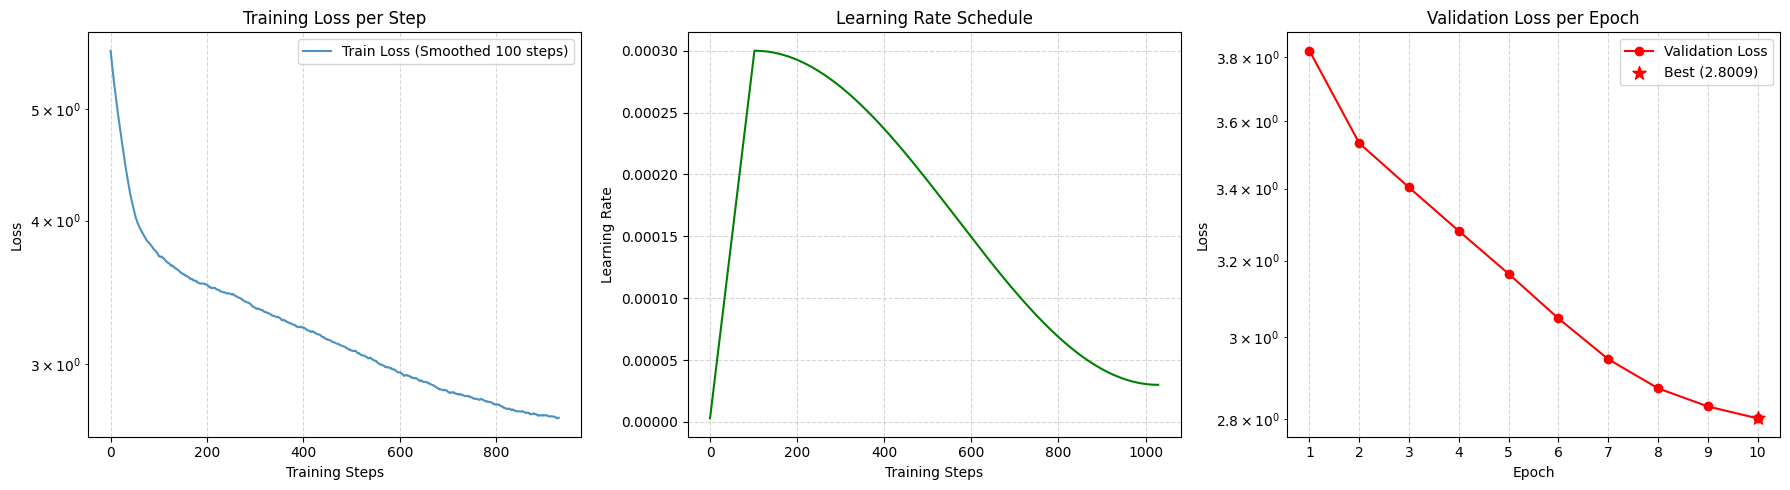

In [14]:
# =============================================================================
# PHASE 7: GPT MODEL TRAINING
# =============================================================================

# Dependencies: Phases 4, 5, 6 classes and functions
# Ensure definitions are available

# --- START CLASS/FUNCTION COPIES (Skip if already defined) ---
# Assume SentencePieceTokenizer, TransformerConfig, GPTDataset,
# GPT model architecture (MHA, FF, Block, GPT) are defined above.
# --- END CLASS/FUNCTION COPIES ---


# --- Helper Functions (Scheduler, EarlyStopping, Evaluation) ---

def get_lr_scheduler(optimizer, total_steps, warmup_ratio=0.1, final_lr_ratio=0.1):
    """ Creates a learning rate scheduler with linear warmup and cosine decay to a final LR. """
    warmup_steps = int(warmup_ratio * total_steps)
    decay_steps = total_steps - warmup_steps
    initial_lr = optimizer.param_groups[0]['lr'] # Get initial LR from optimizer
    final_lr = initial_lr * final_lr_ratio      # Calculate target final LR

    if warmup_steps + decay_steps != total_steps:
         print(f"Warning: warmup ({warmup_steps}) + decay ({decay_steps}) != total ({total_steps}). Adjusting decay.")
         decay_steps = total_steps - warmup_steps

    def lr_lambda(current_step):
        # Linear warmup phase
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay phase
        elif current_step < total_steps:
            progress = float(current_step - warmup_steps) / float(max(1, decay_steps))
            # Cosine annealing formula: 0.5 * (1 + cos(pi * progress))
            # Scale it to decay from 1 down to final_lr_ratio
            cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
            return final_lr_ratio + (1.0 - final_lr_ratio) * cosine_decay
        # Hold final LR after decay phase
        else:
            return final_lr_ratio

    return LambdaLR(optimizer, lr_lambda)

class EarlyStopping:
    """ Stops training early if validation loss doesn't improve after a given patience. """
    def __init__(self, patience=3, min_delta=0.001, verbose=True, path='early_stopping_checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path for the checkpoint to be saved when validation loss improves.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0           # Counts epochs with no improvement
        self.best_loss = float('inf') # Tracks the best validation loss achieved
        self.early_stop = False    # Flag to indicate if training should stop

    def __call__(self, val_loss, model, optimizer, epoch, config, tokenizer_info):
        """ Call instance with current validation loss. """
        # Check if the current loss is an improvement
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                print(f"  EarlyStopping: Validation loss improved ({self.best_loss:.4f} --> {val_loss:.4f}). Saving model...")
            self.best_loss = val_loss
            self.counter = 0
            self.early_stop = False
            # Save the model checkpoint as this is the best model so far
            self.save_checkpoint(val_loss, model, optimizer, epoch, config, tokenizer_info)
        else:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f"  EarlyStopping: Validation loss did not improve. Counter: {self.counter}/{self.patience}")
            # Check if patience is exhausted
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("  EarlyStopping: Patience exhausted! Stopping training.")
        return self.early_stop

    def save_checkpoint(self, val_loss, model, optimizer, epoch, config, tokenizer_info):
        """Saves model checkpoint."""
        try:
            checkpoint = {
                'epoch': epoch + 1, # Save epoch number (1-based)
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': self.best_loss,
                'config': config.to_dict() if hasattr(config, 'to_dict') else config,
                'tokenizer_info': tokenizer_info
            }
            torch.save(checkpoint, self.path)
        except Exception as e:
             print(f"  Error saving early stopping checkpoint to '{self.path}': {e}")


@torch.no_grad() # Decorator disables gradient calculation
def evaluate_model(model, dataloader, device, config):
    """ Evaluates the model on a given dataloader (e.g., validation set). """
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    total_batches = 0
    # Use tqdm for progress bar, disable nested bar for cleaner output during eval
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False, disable=True)

    for x, y in progress_bar:
        x, y = x.to(device), y.to(device) # Move data to the correct device
        logits, loss = model(x, y) # Forward pass

        # Accumulate loss if valid
        if loss is not None and not torch.isnan(loss) and not torch.isinf(loss):
            total_loss += loss.item()
            total_batches += 1
        else:
             # Fallback if model doesn't return loss or loss is invalid
             print("Warning: Model forward pass returned invalid loss during evaluation. Calculating manually.")
             pad_id = config.pad_token_id if hasattr(config, 'pad_token_id') else -100
             try:
                 loss_manual = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=pad_id)
                 if not torch.isnan(loss_manual) and not torch.isinf(loss_manual):
                     total_loss += loss_manual.item()
                     total_batches += 1
                 else:
                      print("Warning: Manual loss calculation also resulted in invalid loss.")
             except Exception as e_manual:
                 print(f"Warning: Error during manual loss calculation: {e_manual}")


    model.train() # Set model back to training mode
    # Calculate average loss
    return total_loss / total_batches if total_batches > 0 else float('inf')

# =============================================================================
# PHASE 7: MAIN TRAINING FUNCTION
# =============================================================================

def train_model(model, config, tokenizer, tokens, val_split=0.1, model_save_prefix='gpt_trained_model'):
    """ Trains the GPT model. """
    print("\n" + "="*60)
    print("PHASE 7: GPT MODEL TRAINING")
    print("="*60)

    # 1. Validate Inputs and Setup Device
    if not all([model, config, tokenizer]) or tokens is None:
        print("Error: Missing required arguments (model, config, tokenizer, or tokens).")
        return None
    if not tokens:
        print("Error: Token list is empty. Cannot train.")
        return model # Return untrained model if tokens are empty

    try:
        device = next(model.parameters()).device
    except StopIteration:
        print("Error: Model has no parameters. Cannot determine device.")
        return None
    print(f"Training device: {device}")
    print(f"Configuration:\n{config}")
    print(f"Tokenizer: SPM (Vocab: {tokenizer.vocab_size}, PAD ID: {tokenizer.pad_id})")
    print(f"Tokens for Dataset: {len(tokens):,}")

    # 2. Prepare Datasets and DataLoaders
    print("\nPreparing Datasets and DataLoaders...")
    try:
        # Use context length and pad ID from the final config
        full_dataset = GPTDataset(tokens, config.context_length, config.pad_token_id, stride=config.context_length // 2) # Overlapping stride
        if len(full_dataset) == 0:
             print("Error: Dataset created has 0 samples. Check tokens and context length.")
             return model # Return untrained model

        train_dataset, val_dataset = None, None
        # Split dataset if validation ratio is valid
        if 0 < val_split < 1:
            val_size = int(val_split * len(full_dataset))
            train_size = len(full_dataset) - val_size
            # Ensure both splits have at least one sample
            if train_size > 0 and val_size > 0:
                train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)) # Use generator for reproducibility
            else:
                train_dataset = full_dataset
                print(f"Warning: Not enough samples ({len(full_dataset)}) to create a validation split with ratio {val_split}. Using all data for training.")
        else:
            train_dataset = full_dataset
            print("Validation split ratio is not valid (should be > 0 and < 1). Using all data for training.")

        if train_dataset: print(f"Training Dataset: {len(train_dataset)} samples.")
        if val_dataset: print(f"Validation Dataset: {len(val_dataset)} samples.")

        # Determine number of workers based on CPU cores
        num_workers = min(4, os.cpu_count() // 2 if os.cpu_count() else 1); num_workers = max(1, num_workers)
        print(f"Using {num_workers} dataloader workers.")

        # Create DataLoaders
        # pin_memory=True speeds up CPU->GPU transfer if using CUDA
        # drop_last=True for training loader ensures consistent batch sizes (can slightly reduce data used)
        train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=(device.type == 'cuda'), num_workers=num_workers, drop_last=True) if train_dataset else None
        val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size * 2, shuffle=False, pin_memory=(device.type == 'cuda'), num_workers=num_workers, drop_last=False) if val_dataset else None # Larger batch size for validation is often ok

        if not train_dataloader:
            print("Error: Could not create training DataLoader.")
            return model
    except Exception as e:
        print(f"Error creating Datasets/DataLoaders: {e}")
        traceback.print_exc()
        return model

    # 3. Configure Optimizer and Scheduler
    print("\nConfiguring Optimizer and Scheduler...")
    # AdamW is a common choice for Transformers
    optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, betas=(0.9, 0.95), eps=1e-8)

    # Calculate total training steps for scheduler
    steps_per_epoch = len(train_dataloader)
    total_steps = config.num_epochs * steps_per_epoch
    if total_steps == 0:
        print("Error: Calculated total_steps is 0. Check dataloader length and num_epochs.")
        return model
    print(f"Steps per epoch: {steps_per_epoch}, Total training steps: {total_steps}")

    # Create learning rate scheduler
    scheduler = get_lr_scheduler(optimizer, total_steps, warmup_ratio=0.1, final_lr_ratio=0.1) # 10% warmup, decay to 10% of initial LR

    # 4. Initialize Early Stopping and Tracking
    # Only use EarlyStopping if there's a validation set
    early_stopping_path = f'{model_save_prefix}_best_early_stopping.pt'
    early_stopping = EarlyStopping(patience=3, verbose=True, path=early_stopping_path) if val_dataloader else None
    if early_stopping: print(f"Early stopping enabled (patience=3). Best model will be saved to '{early_stopping_path}'")

    # Lists to store metrics for plotting
    train_losses_step, val_losses_epoch, learning_rates_step = [], [], []
    best_val_loss = float('inf')
    start_time = time.time()
    # Gather tokenizer info for saving checkpoints
    tokenizer_info_for_save = {'prefix': tokenizer.model_prefix, 'vocab_size': tokenizer.vocab_size, 'pad_id': tokenizer.pad_id, 'info_path': tokenizer.info_path}


    # 5. Training Loop
    print(f"\n--- Starting Training ({config.num_epochs} epochs) ---")
    training_interrupted = False
    last_completed_epoch = -1 # Track the last fully completed epoch
    avg_epoch_train_loss = None
    current_val_loss = None

    try:
        for epoch in range(config.num_epochs):
            epoch_start_time = time.time()
            model.train() # Set model to training mode
            epoch_train_loss = 0.0
            steps_in_epoch = 0

            # Progress bar for the current epoch
            progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}", leave=True)

            for batch_idx, (x, y) in enumerate(progress_bar):
                x, y = x.to(device), y.to(device) # Move batch to device

                # Forward pass
                logits, loss = model(x, y)

                # Handle potential issues with loss calculation
                if loss is None or torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Invalid loss detected at epoch {epoch+1}, step {batch_idx}. Skipping batch.")
                    continue # Skip gradient update for this batch

                # Backward pass and optimization step
                optimizer.zero_grad(set_to_none=True) # More efficient zeroing
                loss.backward()
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                # Update learning rate scheduler
                scheduler.step()

                # Track metrics
                loss_value = loss.item()
                train_losses_step.append(loss_value)
                epoch_train_loss += loss_value
                learning_rates_step.append(scheduler.get_last_lr()[0]) # Get current LR
                steps_in_epoch += 1

                # Update progress bar postfix
                progress_bar.set_postfix(loss=f"{loss_value:.4f}", avg_loss=f"{(epoch_train_loss/steps_in_epoch):.4f}", lr=f"{scheduler.get_last_lr()[0]:.2e}")

            # --- End of Epoch ---
            avg_epoch_train_loss = epoch_train_loss / steps_in_epoch if steps_in_epoch > 0 else 0.0
            epoch_duration = time.time() - epoch_start_time
            print(f"\nEnd Epoch {epoch+1}/{config.num_epochs} | Duration: {epoch_duration:.2f}s | Avg Train Loss: {avg_epoch_train_loss:.4f}")

            # Validation Step (if validation loader exists)
            current_val_loss = float('inf')
            if val_dataloader:
                current_val_loss = evaluate_model(model, val_dataloader, device, config)
                val_losses_epoch.append(current_val_loss)
                print(f"  Validation Loss: {current_val_loss:.4f}")

                # Checkpoint saving based on validation loss
                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    best_model_path = f'{model_save_prefix}_best_val.pt'
                    checkpoint = {
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_loss': best_val_loss,
                        'config': config.to_dict(),
                        'tokenizer_info': tokenizer_info_for_save
                    }
                    try:
                        torch.save(checkpoint, best_model_path)
                        print(f"  ✨ New best validation model saved: '{best_model_path}'")
                    except Exception as e:
                        print(f"  Error saving best validation checkpoint: {e}")

                # Check for early stopping
                if early_stopping and early_stopping(current_val_loss, model, optimizer, epoch, config, tokenizer_info_for_save):
                    print("--- Early Stopping Triggered ---")
                    break # Exit the training loop
            else:
                # Save model checkpoint every epoch if no validation set
                 epoch_model_path = f'{model_save_prefix}_epoch{epoch+1}.pt'
                 checkpoint = {
                     'epoch': epoch + 1,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'train_loss': avg_epoch_train_loss, # Save training loss instead of val loss
                     'config': config.to_dict(),
                     'tokenizer_info': tokenizer_info_for_save
                 }
                 try:
                     torch.save(checkpoint, epoch_model_path)
                     # print(f"  Epoch model saved: '{epoch_model_path}'") # Less verbose saving message
                 except Exception as e:
                     print(f"  Error saving epoch checkpoint: {e}")

            last_completed_epoch = epoch # Mark epoch as completed (0-based index)

    except KeyboardInterrupt:
        print("\n--- Training Interrupted Manually ---")
        training_interrupted = True
    except Exception as e:
        print(f"\n--- Error During Training: {e} ---")
        traceback.print_exc()
        training_interrupted = True

    # 6. End of Training
    total_training_time = time.time() - start_time
    status = "Interrupted" if training_interrupted else "Completed"
    print(f"\n--- Training {status} ---")
    print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
    if val_dataloader:
        print(f"Best Validation Loss Achieved: {best_val_loss:.4f}")
    print(f"Last completed epoch: {last_completed_epoch + 1}") # Display 1-based epoch

    # 7. Save Final Model Checkpoint
    final_model_path = f'{model_save_prefix}_final.pt'
    final_checkpoint = {
        'epoch': last_completed_epoch + 1, # Save the number of the last completed epoch (1-based)
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_train_loss': avg_epoch_train_loss, # Last epoch's average train loss
        'final_val_loss': current_val_loss if val_dataloader else None, # Last validation loss if available
        'config': config.to_dict(),
        'tokenizer_info': tokenizer_info_for_save
    }
    try:
        torch.save(final_checkpoint, final_model_path)
        print(f"Final model checkpoint saved: '{final_model_path}'")
    except Exception as e:
        print(f"Error saving final model checkpoint: {e}")

    # 8. Tokenizer Reference
    print(f"\nTokenizer used (prefix): '{tokenizer.model_prefix}'")
    # print(f"  Files: {tokenizer.model_path}, {tokenizer.vocab_path}, {tokenizer.info_path}") # Less verbose

    # 9. Visualize Learning Curves
    print("\nGenerating learning curves plot...")
    try:
        plt.figure(figsize=(18, 5)) # Wider figure

        # Plot 1: Training Loss per Step (Smoothed)
        plt.subplot(1, 3, 1)
        if len(train_losses_step) > 100: # Apply smoothing only if enough steps
             # Use a simple moving average
             smoothed_train_loss = np.convolve(train_losses_step, np.ones(100)/100, mode='valid')
             plt.plot(smoothed_train_loss, alpha=0.8, label=f'Train Loss (Smoothed {100} steps)')
        elif train_losses_step:
             plt.plot(train_losses_step, alpha=0.8, label='Train Loss')
        plt.title('Training Loss per Step')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.yscale('log') # Use log scale for loss often helpful

        # Plot 2: Learning Rate per Step
        plt.subplot(1, 3, 2)
        if learning_rates_step:
            plt.plot(learning_rates_step, color='g')
            plt.title('Learning Rate Schedule')
            plt.xlabel('Training Steps')
            plt.ylabel('Learning Rate')
            plt.grid(True, linestyle='--', alpha=0.5)
        else:
            plt.title('Learning Rate (No Data)')

        # Plot 3: Validation Loss per Epoch
        plt.subplot(1, 3, 3)
        if val_losses_epoch:
            epochs_ran = range(1, len(val_losses_epoch) + 1)
            plt.plot(epochs_ran, val_losses_epoch, marker='o', linestyle='-', color='r', label='Validation Loss')
            # Highlight the best validation loss point
            if best_val_loss != float('inf') and best_val_loss in val_losses_epoch:
                best_epoch_idx = val_losses_epoch.index(best_val_loss)
                best_epoch = epochs_ran[best_epoch_idx]
                plt.scatter(best_epoch, best_val_loss, color='red', s=100, label=f'Best ({best_val_loss:.4f})', zorder=5, marker='*')
            plt.title('Validation Loss per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.xticks(epochs_ran) # Ensure integer ticks for epochs
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.yscale('log') # Use log scale for loss often helpful
        else:
             plt.title('Validation Loss (No Data)')


        plt.tight_layout() # Adjust spacing between plots
        plot_path = f'{model_save_prefix}_learning_curves.png'
        plt.savefig(plot_path)
        print(f"Learning curves plot saved: '{plot_path}'")
        # plt.show() # Optional: display plot in notebook/IDE

    except Exception as e:
        print(f"Error generating learning curves plot: {e}")
        traceback.print_exc()

    print("\n" + "="*60)
    print("PHASE 7 TRAINING COMPLETE")
    print("="*60)
    return model # Return the trained model instance

# --- EXECUTE PHASE 7 ---

# *** IMPORTANT: Ensure variables from Phase 6 are available ***
# Execute the Phase 6 cell before this one.
# Required variables: model_p6, config_p6, tokenizer_p6, tokens_p6

print("\n--- Starting Phase 7 Execution ---")

# Check if necessary variables exist from Phase 6
if ('model_p6' in locals() and model_p6 is not None and
    'config_p6' in locals() and config_p6 is not None and
    'tokenizer_p6' in locals() and tokenizer_p6 is not None and
    'tokens_p6' in locals() and tokens_p6 is not None):

    print("Variables from Phase 6 found. Proceeding to training...")

    # --- Training Parameters ---
    VAL_SPLIT_RATIO_P7 = 0.05  # Use 5% of data for validation (adjust if needed)
    # Prefix for saving model checkpoints and plots for this training run
    MODEL_SAVE_PREFIX_P7 = "gpt_harry_potter_trained"

    # --- Call the Training Function ---
    # Pass the objects obtained from Phase 6
    trained_model_p7 = train_model(
        model=model_p6,
        config=config_p6,
        tokenizer=tokenizer_p6,
        tokens=tokens_p6,
        val_split=VAL_SPLIT_RATIO_P7,
        model_save_prefix=MODEL_SAVE_PREFIX_P7
    )

    # --- Quick Post-Training Test (Optional) ---
    if trained_model_p7:
        print("\n--- Quick Post-Training Test ---")
        # Ensure correct model and tokenizer are used
        current_model = trained_model_p7
        current_tokenizer = tokenizer_p6 # Use the tokenizer passed to train_model

        try:
            device_p7 = next(current_model.parameters()).device
        except StopIteration:
            device_p7 = torch.device('cpu') # Fallback if model has no params
            print("Warning: Model has no parameters, setting device to CPU.")

        current_model.eval() # Set model to evaluation mode

        # Get the BOS token string from the tokenizer
        try:
            bos_token_string = current_tokenizer.special_tokens.get('bos_token', '[BOS]')
            if not bos_token_string: # Handle empty string case
                 bos_token_string = "" # Or maybe "[UNK]"? Let's use empty for now.
        except Exception:
            print("Warning: Could not get 'bos_token' from tokenizer. Using empty start.")
            bos_token_string = "" # Fallback

        # Example prompt
        prompt_p7 = bos_token_string + " Harry looked around the" if bos_token_string else "Harry looked around the"
        print(f"Prompt: {prompt_p7}")

        # Check if prompt is empty after potential BOS addition
        if not prompt_p7.strip():
             print("Error: Prompt is empty, cannot generate.")
        else:
            try:
                # Encode the prompt
                input_ids_p7 = current_tokenizer.encode(prompt_p7, add_bos=False, add_eos=False)
                # Handle case where encoding returns empty list (e.g., only OOV tokens?)
                if not input_ids_p7:
                     print(f"Warning: Encoding prompt '{prompt_p7}' resulted in empty list. Using UNK token.")
                     input_ids_p7 = [current_tokenizer.unk_id]

                input_tensor_p7 = torch.tensor([input_ids_p7], dtype=torch.long).to(device_p7)

                # Generate text
                with torch.no_grad():
                    generated_ids_p7 = current_model.generate(
                        idx=input_tensor_p7,
                        max_new_tokens=100, # Generate more tokens
                        temperature=0.7,    # Moderate temperature for coherence
                        top_k=40,           # Use top-k sampling
                        tokenizer=current_tokenizer # Pass tokenizer for EOS detection
                    )
                # Decode the full generated sequence
                full_generated_text = current_tokenizer.decode(generated_ids_p7[0].tolist(), skip_special_tokens=False) # Keep specials initially
                # Decode again, skipping special tokens for cleaner output
                clean_generated_text = current_tokenizer.decode(generated_ids_p7[0].tolist(), skip_special_tokens=True)

                print(f"\nGenerated Text (Full with Specials): {full_generated_text}")
                print(f"\nGenerated Text (Cleaned): {clean_generated_text}")

            except Exception as e_gen:
                print(f"Error during post-training generation: {e_gen}")
                traceback.print_exc()
    else:
        print("\nTraining did not complete or failed, cannot perform post-training test.")

else:
    print("\nCritical Error: Required variables from Phase 6 (model_p6, config_p6, tokenizer_p6, tokens_p6) are not defined or are None.")
    print("Ensure Phase 6 completed successfully without errors before running Phase 7.")
    print("Check the logs from Phase 6 for potential issues.")

In [15]:
# =============================================================================
# PHASE 8: GRADIO INTERFACE - TEXT COMPLETION
# =============================================================================

# --- Text Completion App ---

# Required classes (ensure they are defined above or imported)
# - SentencePieceTokenizer
# - TransformerConfig
# - GPT Model architecture (MultiHeadAttention, FeedForward, TransformerBlock, GPT)

def load_model_for_inference(model_path):
    """Loads a trained model and associated config/tokenizer info from a checkpoint."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at '{model_path}'")

    # Load checkpoint onto CPU first to avoid potential GPU memory issues
    checkpoint = torch.load(model_path, map_location='cpu')

    # Load configuration from checkpoint
    if 'config' in checkpoint and isinstance(checkpoint['config'], dict):
        config_dict = checkpoint['config']
        # Create config instance using the class method
        config = TransformerConfig.from_dict(config_dict)
        print(f"Configuration loaded from checkpoint (Vocab: {config.vocab_size}, Layers: {config.num_layers})")
    else:
        # Fallback or raise error if config is missing/invalid
        raise ValueError("Valid 'config' dictionary not found in checkpoint.")

    # Instantiate the model with the loaded configuration
    model = GPT(config)

    # Load the model's state dictionary
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model state dictionary loaded successfully from '{model_path}'")
    except KeyError:
        raise KeyError("'model_state_dict' not found in the checkpoint.")
    except Exception as e:
        print(f"Error loading state dict: {e}")
        # Optionally try loading with strict=False if keys mismatch, but this indicates potential issues
        # model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        # print("Warning: Loaded state dict with strict=False due to key mismatches.")
        raise e # Re-raise the error for clarity

    # Get tokenizer information from the checkpoint
    tokenizer_info = checkpoint.get('tokenizer_info', {})
    tokenizer_prefix = tokenizer_info.get('prefix', 'spm_harry_potter') # Default prefix if not found
    if not tokenizer_prefix:
        print("Warning: Tokenizer prefix not found in checkpoint info. Using default 'spm_harry_potter'.")
        tokenizer_prefix = 'spm_harry_potter'

    print(f"Tokenizer prefix from checkpoint: '{tokenizer_prefix}'")

    return model, config, tokenizer_prefix

def generate_completion_text(
    prompt,
    model,
    tokenizer,
    device, # Added device argument
    max_new_tokens=150,
    temperature=0.7,
    top_k=50,
    add_bos=True
):
    """Generates text completion based on a given prompt."""
    if not prompt or not prompt.strip():
        return "Please enter some text to complete."

    model.eval() # Ensure model is in evaluation mode

    try:
        # Prepare the prompt (optionally add BOS token)
        if add_bos:
            # Safely get BOS token string
            bos_token = tokenizer.special_tokens.get('bos_token', '')
            full_prompt = (bos_token + " " + prompt).strip() if bos_token else prompt
        else:
            full_prompt = prompt

        # print(f"DEBUG - Processed Prompt: '{full_prompt}'") # Optional Debug

        # Tokenize the prompt
        input_ids = tokenizer.encode(full_prompt, add_bos=False, add_eos=False)

        # Handle empty encoding result
        if not input_ids:
            print(f"Warning: Encoding the prompt '{full_prompt}' resulted in an empty list. Using UNK token.")
            input_ids = [tokenizer.unk_id]

        # Convert to tensor and move to device
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

        # Generate text using the model's method
        with torch.no_grad():
            generated_ids = model.generate(
                input_tensor,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_k=top_k,
                tokenizer=tokenizer # Pass tokenizer for EOS detection
            )

        # Decode the generated IDs
        # Decode with specials retained
        full_text_special = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=False)
        # Decode skipping specials for cleaner output
        clean_text = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)

        # Attempt to extract only the generated part (simple approach)
        # This might not be perfect if the prompt itself contains special tokens
        # that are removed by skip_special_tokens=True
        prompt_clean_approx = tokenizer.decode(input_ids, skip_special_tokens=True)
        generated_part = clean_text
        if clean_text.startswith(prompt_clean_approx):
             generated_part = clean_text[len(prompt_clean_approx):].strip()


        result = {
            "prompt": prompt,
            "processed_prompt": full_prompt,
            "full_text_with_specials": full_text_special,
            "clean_text_completion": clean_text, # Full sequence clean
            "generated_part_only": generated_part # Attempt to get only new part
        }

        # print(f"DEBUG - Generation Result: {result}") # Optional Debug

        return result

    except Exception as e:
        print(f"Error during text generation: {str(e)}")
        traceback.print_exc()
        return f"Error during generation: {str(e)}"

# Gradio Interface Function for Text Completion
def create_completion_interface(model_path, default_tokenizer_prefix):
    """Creates and launches the Gradio interface for text completion."""
    try:
        # Load the trained model and associated info
        model, config, tokenizer_prefix_from_model = load_model_for_inference(model_path)

        # Prioritize tokenizer prefix from the model checkpoint if available
        if tokenizer_prefix_from_model:
            tokenizer_prefix = tokenizer_prefix_from_model
            print(f"Using tokenizer prefix from model checkpoint: '{tokenizer_prefix}'")
        else:
            tokenizer_prefix = default_tokenizer_prefix
            print(f"Using default tokenizer prefix: '{tokenizer_prefix}'")

        # Load the corresponding tokenizer
        tokenizer = SentencePieceTokenizer()
        tokenizer.load(tokenizer_prefix) # Assumes .model and potentially _info.json exist

        # Determine the device and move the model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Model moved to device: {device}")

        # Function to handle Gradio prediction logic
        def predict(
            prompt,
            max_tokens,
            temperature,
            top_k,
            add_bos,
            show_debug_json,
            show_tokens # Added show_tokens option
        ):
            # Call the generation function
            result = generate_completion_text(
                prompt=prompt,
                model=model,
                tokenizer=tokenizer,
                device=device, # Pass the device
                max_new_tokens=int(max_tokens), # Ensure integer
                temperature=float(temperature), # Ensure float
                top_k=int(top_k) if top_k > 0 else None, # Ensure int, pass None if 0
                add_bos=add_bos
            )

            # Handle potential error string from generation
            if isinstance(result, str):
                return result # Return the error message directly

            # Format the output response
            response_md = ""

            # Optionally show technical details (JSON)
            if show_debug_json:
                # Use ensure_ascii=False for proper unicode display
                response_md += "**Technical Details (JSON):**\n"
                response_md += "```json\n" + json.dumps(result, indent=2, ensure_ascii=False) + "\n```\n\n---\n\n"

            # Optionally show input tokens
            if show_tokens:
                try:
                     input_ids_display = tokenizer.encode(result['processed_prompt'], add_bos=False, add_eos=False)
                     tokens_display = tokenizer.convert_ids_to_tokens(input_ids_display)
                     display_pieces = [p.replace(' ', '_') for p in tokens_display] # Show spaces clearly
                     response_md += "**Input Prompt Tokens:**\n"
                     response_md += f"`{display_pieces}`\n\n---\n\n"
                except Exception as e_tok:
                     response_md += f"_(Error displaying tokens: {e_tok})_\n\n"


            # Always display the cleaned generated text (prompt + completion)
            response_md += "**Generated Text (Prompt + Completion):**\n"
            # Use the cleaned full text for display
            response_md += f"{result['clean_text_completion']}"

            return response_md

        # --- Define Gradio Blocks Interface ---
        with gr.Blocks(title="Harry Potter Text Completer") as demo:
            gr.Markdown("# 🧙‍♂️ Harry Potter Text Completer")
            gr.Markdown("Enter some starting text, and the model will complete it in the style of Harry Potter.")

            with gr.Tab("Text Completion"):
                with gr.Row():
                    # Left column for input and main settings
                    with gr.Column(scale=4):
                        prompt_input = gr.Textbox(
                            placeholder="Type a starting sentence here (e.g., 'Harry looked at Hermione and')",
                            label="Starting Text",
                            lines=3
                        )
                    # Right column for advanced settings
                    with gr.Column(scale=1):
                        with gr.Accordion("Generation Settings", open=True):
                            max_tokens_slider = gr.Slider(
                                minimum=10, maximum=500, step=10, value=150,
                                label="Max Tokens to Generate"
                            )
                            temperature_slider = gr.Slider(
                                minimum=0.0, maximum=1.5, step=0.05, value=0.7, # Allow temp=0 for greedy
                                label="Temperature (0=greedy)"
                            )
                            top_k_slider = gr.Slider(
                                minimum=0, maximum=100, step=1, value=40, # Allow top_k=0 to disable
                                label="Top-K Sampling (0=disabled)"
                            )
                        with gr.Accordion("Input/Output Options", open=False):
                             add_bos_checkbox = gr.Checkbox(
                                 value=True,
                                 label="Add BOS token ([BOS]) to input"
                             )
                             show_tokens_checkbox = gr.Checkbox(
                                 value=False,
                                 label="Show Input Tokens"
                             )
                             debug_json_checkbox = gr.Checkbox(
                                 value=False,
                                 label="Show Technical Details (JSON)"
                             )


                generate_btn = gr.Button("Generate Completion")
                output_markdown = gr.Markdown(label="Generated Text") # Use Markdown for better formatting

                # Connect button click to prediction function
                generate_btn.click(
                    predict,
                    inputs=[
                        prompt_input,
                        max_tokens_slider,
                        temperature_slider,
                        top_k_slider,
                        add_bos_checkbox,
                        debug_json_checkbox,
                        show_tokens_checkbox
                    ],
                    outputs=output_markdown
                )

                # Add examples
                gr.Examples(
                    [
                        ["Harry looked at Hermione and"],
                        ["It was a dark night at Hogwarts when"],
                        ["Ron pulled out his wand and"],
                        ["Dumbledore slowly approached the table and said"],
                        ["The Quidditch match was about to begin"]
                    ],
                    inputs=prompt_input # Link examples to the prompt input box
                )

            # Information Tab
            with gr.Accordion("Model Information", open=False):
                # Display details about the loaded model and tokenizer
                gr.Markdown(f"""
                *   **Model Checkpoint:** `{Path(model_path).name}`
                *   **Tokenizer Prefix:** `{tokenizer_prefix}`
                *   **Vocabulary Size:** `{config.vocab_size}`
                *   **Transformer Layers:** `{config.num_layers}`
                *   **Embedding Dimension:** `{config.embed_dim}`
                *   **Attention Heads:** `{config.num_heads}`
                *   **Context Length:** `{config.context_length}`
                *   **Device:** `{device}`
                """)

        return demo

    except FileNotFoundError as e:
        print(f"Error: {e}")
        # Create an error interface if model/tokenizer loading fails
        with gr.Blocks(title="Text Completer - Error") as error_demo:
            gr.Markdown("# ❌ Error Loading Text Completer")
            gr.Markdown(f"Could not initialize the application. Please check the model path and tokenizer files.\n\n**Error details:**\n`{str(e)}`")
        return error_demo
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        traceback.print_exc()
        # Create a generic error interface
        with gr.Blocks(title="Text Completer - Error") as error_demo:
            gr.Markdown("# ❌ Error Loading Text Completer")
            gr.Markdown(f"An unexpected error occurred during initialization:\n\n`{str(e)}`")
        return error_demo

# --- Execute Text Completion App ---
if __name__ == "__main__":
    print("\n--- Setting up Gradio Interfaces ---")

    # Configuration for the apps (adjust paths as needed)
    # Assumes Phase 7 saved a final model
    COMPLETER_MODEL_PATH = f"{MODEL_SAVE_PREFIX_P7}_final.pt" if 'MODEL_SAVE_PREFIX_P7' in locals() else "gpt_harry_potter_trained_final.pt"
    # Assumes Phase 4 defined the tokenizer prefix
    COMPLETER_TOKENIZER_PREFIX = TOKENIZER_PREFIX_P4 if 'TOKENIZER_PREFIX_P4' in locals() else "spm_harry_potter"

    print(f"Attempting to load completer model from: {COMPLETER_MODEL_PATH}")
    print(f"Using tokenizer prefix: {COMPLETER_TOKENIZER_PREFIX}")

    # Create and launch the text completion interface
    completion_app = create_completion_interface(COMPLETER_MODEL_PATH, COMPLETER_TOKENIZER_PREFIX)
    completion_app.launch(share=True) # share=True creates a temporary public link (useful in Colab)
    # Use share=False or omit for local running without public link
    print("\n--- To launch Text Completion App (if not already running): completion_app.launch() ---")




--- Setting up Gradio Interfaces ---
Attempting to load completer model from: gpt_harry_potter_trained_final.pt
Using tokenizer prefix: spm_harry_potter
Configuration loaded from checkpoint (Vocab: 6814, Layers: 6)
GPT Model Initialized. Parameters (excluding pos embeddings): 25,892,864
Using PAD token ID for loss calculation: 4
Model state dictionary loaded successfully from 'gpt_harry_potter_trained_final.pt'
Tokenizer prefix from checkpoint: 'spm_harry_potter'
Using tokenizer prefix from model checkpoint: 'spm_harry_potter'
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6814 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
Model moved to device: cuda
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6acd4ffae84ff1ed38.gradio.live

This share link expires in 72 hours. 


--- To launch Text Completion App (if not already running): completion_app.launch() ---
